### Daily extremes via GEV fitting ###

Fitting GEV's to the time series of block minima/maxima from the model and observations.

Start with temperature over the UK, as we are happy with how this is processed.

Next look at 10m wind speed for the GB box.

In [1]:
%matplotlib inline

# Local imports
import os
import sys
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# import the temperature data
df_model_tas = pd.read_csv(
    f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv"
)

# set up the djf winter years
djf_winter_years = np.arange(1, 11 + 1)

# set up a new dataframe to append to
df_model_tas_djf = pd.DataFrame()

# loop over the winter years
for i, wyear in enumerate(djf_winter_years):
    # set up the leads to extract
    leads = np.arange(31 + (i * 360), 31 + 90 + (i * 360))

    # extract the data
    df_model_leads_this = df_model_tas[df_model_tas["lead"].isin(leads)]

    # include a new column
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_tas_djf = pd.concat([df_model_tas_djf, df_model_leads_this])

In [3]:
# subset model djf tas to the first winter
df_model_tas_djf_first = df_model_tas_djf

# add the column for effective dec year to the model data
df_model_tas_djf_first["effective_dec_year"] = df_model_tas_djf_first["init_year"] + (df_model_tas_djf_first["winter_year"] - 1)

In [4]:
# import the observed data
# load the obs data
df_obs_tas = pd.read_csv(
    f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv"
)

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"], origin="1950-01-01", unit="D")

# subset the obs data to D, J, F
df_obs_tas = df_obs_tas[df_obs_tas["time"].dt.month.isin([12, 1, 2])]

# new column for temp in C
df_obs_tas["data_c"] = df_obs_tas["data"] - 273.15

In [5]:
def determine_effective_dec_year(row):
    year = row["time"].year
    month = row["time"].month
    if month in [1, 2, 3]:
        return year - 1
    elif month in [10, 11, 12]:
        return year
    else:
        return None
    
# apply the effective dec year to the obs data
df_obs_tas["effective_dec_year"] = df_obs_tas.apply(
    lambda row: determine_effective_dec_year(row), axis=1
)

In [6]:
# # Limit both datasets between 1960 and 2019
# df_model_tas_djf_first = df_model_tas_djf_first[
#     df_model_tas_djf_first["effective_dec_year"].between(1960, 2017)
# ]
df_obs_tas = df_obs_tas[df_obs_tas["effective_dec_year"].between(1960, 2017)]

# create new columns for data_c inh df_model_tas_djf_first
df_model_tas_djf_first["data_c"] = df_model_tas_djf_first["data"] - 273.15

In [7]:
df_obs_tas.tail()

,time,data,data_c,effective_dec_year
21239,2018-02-24,275.004977,1.854977,2017
21240,2018-02-25,274.473160,1.323160,2017
21241,2018-02-26,273.135263,-0.014737,2017
21242,2018-02-27,271.899134,-1.250866,2017
21243,2018-02-28,269.332502,-3.817498,2017


In [8]:
df_model_tas_djf_first.tail()

,init_year,member,lead,data,winter_year,effective_dec_year,data_c
2212475,2018,10,3716,274.098134,11,2028,0.948134
2212476,2018,10,3717,274.953301,11,2028,1.803301
2212477,2018,10,3718,275.889982,11,2028,2.739982
2212478,2018,10,3719,275.992503,11,2028,2.842503
2212479,2018,10,3720,276.026317,11,2028,2.876317


In [9]:
# Now calculate the lowest temperature day for each effective dec year
df_obs_lowest_tas_day_djf = pd.DataFrame()

# loop over the effective dec years
for year in df_obs_tas["effective_dec_year"].unique():
    # subset the data
    df_this = df_obs_tas[
        df_obs_tas["effective_dec_year"] == year
    ]

    # find the lowest wind day
    lowest_tas_day = df_this["data_c"].idxmin()

    # Create a new dataframe
    df_new = pd.DataFrame(
        {
            "effective_dec_year": [year],
            "time": [lowest_tas_day],
            "data": [df_this.loc[lowest_tas_day, "data_c"]],
        }
    )

    # Append to the new dataframe
    df_obs_lowest_tas_day_djf = pd.concat([df_obs_lowest_tas_day_djf, df_new])

In [10]:
df_model_tas_djf_first.tail()

,init_year,member,lead,data,winter_year,effective_dec_year,data_c
2212475,2018,10,3716,274.098134,11,2028,0.948134
2212476,2018,10,3717,274.953301,11,2028,1.803301
2212477,2018,10,3718,275.889982,11,2028,2.739982
2212478,2018,10,3719,275.992503,11,2028,2.842503
2212479,2018,10,3720,276.026317,11,2028,2.876317


In [11]:
df_model_tas_djf_first["winter_year"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [12]:
# same for the model data
df_model_lowest_tas_day_djf = pd.DataFrame()

# loop over the effective dec years
for init_year in df_model_tas_djf_first["init_year"].unique():
    for member in df_model_tas_djf_first["member"].unique():
        for winter_year in df_model_tas_djf_first["winter_year"].unique():
            # subset the data
            df_this = df_model_tas_djf_first[
                (df_model_tas_djf_first["init_year"] == init_year)
                & (df_model_tas_djf_first["member"] == member)
                & (df_model_tas_djf_first["winter_year"] == winter_year)
            ]

            # if df_this is an empty sequence, print th init_year, member and winter_year
            if df_this.empty:
                print(f"init_year: {init_year}, member: {member}, winter_year: {winter_year}")

            # find the lowest wind day
            lowest_tas_day = df_this["data_c"].idxmin()

            # Create a new dataframe
            df_new = pd.DataFrame(
                {
                    "init_year": [init_year],
                    "member": [member],
                    "winter_year": [winter_year],
                    "time": [lowest_tas_day],
                    "data": [df_this.loc[lowest_tas_day, "data_c"]],
                }
            )

            # Append to the new dataframe
            df_model_lowest_tas_day_djf = pd.concat([df_model_lowest_tas_day_djf, df_new])

In [13]:
import scipy.stats as stats

# calculate the ensmean slope and intercept
dps_slopes = np.zeros(10)
dps_intercepts = np.zeros(10)

# Loop over the members
for i, member in enumerate(df_model_lowest_tas_day_djf["member"].unique()):
    # subset the data
    df_this = df_model_lowest_tas_day_djf[
        df_model_lowest_tas_day_djf["member"] == member
    ]

    # for each init_year, group by winter_year and calculate the mean
    df_this = df_this.groupby("init_year").mean().reset_index()

    # # print(df_this)
    # print(df_this)

    # fit a linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_this["init_year"],
        df_this["data"],
    )

    dps_slopes[i] = slope
    dps_intercepts[i] = intercept

# Calculate the ensemble mean slope and intercept
dps_slope = dps_slopes.mean()
dps_intercept = dps_intercepts.mean()

# Set up the model trend line
model_trend_line = dps_intercept + dps_slope * df_model_lowest_tas_day_djf["init_year"]

# determine the finla point in the trend line
final_point_model_tl = model_trend_line.iloc[-1]

df_model_lowest_tas_day_djf["data_dt"] = final_point_model_tl - model_trend_line + df_model_lowest_tas_day_djf["data"]

# create a new column in df_model_lowest_tas_day_djf for the data_dt
# which is the residual after the linear trend has been removed
# df_model_lowest_tas_day_djf["data_dt"] = df_model_lowest_tas_day_djf["data"] - (dps_intercept + dps_slope * df_model_lowest_tas_day_djf["init_year"])
# df_model_lowest_tas_day_djf["data_tas_worst_wind_dt"] = df_model_lowest_tas_day_djf["data_tas_worst_wind"] - (dps_intercept + dps_slope * df_model_lowest_tas_day_djf["effective_dec_year"])

In [14]:
# Do the same for the obs data
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_obs_lowest_tas_day_djf["effective_dec_year"],
    df_obs_lowest_tas_day_djf["data"],
)

# create a new column in df_obs_lowest_tas_day_djf for the data_dt
# which is the residual after the linear trend has been removed
df_obs_lowest_tas_day_djf["data_dt"] = df_obs_lowest_tas_day_djf["data"] - (intercept + slope * df_obs_lowest_tas_day_djf["effective_dec_year"])

In [15]:
# set up effective dec year for the model data
df_model_lowest_tas_day_djf["effective_dec_year"] = df_model_lowest_tas_day_djf["init_year"] + (df_model_lowest_tas_day_djf["winter_year"] - 1)

Text(0.5, 1.0, 'UK DJF block minima temperature 1960-2017')

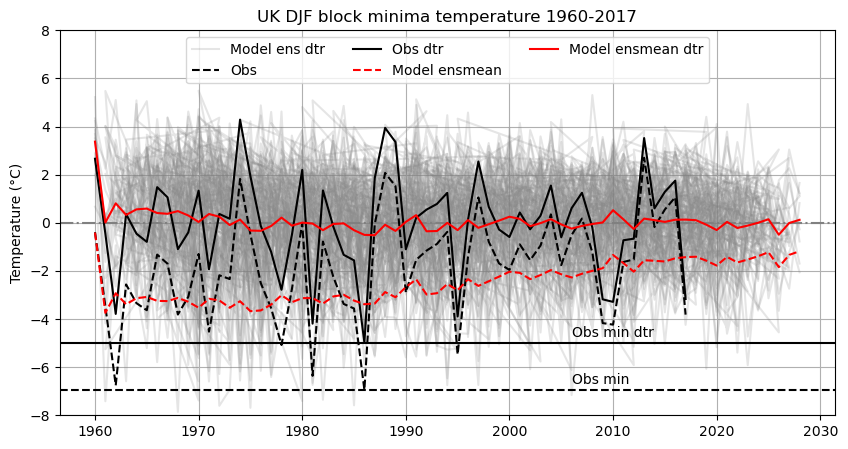

In [16]:
# set up a figure
# set up a figure with size 10x5
fig, ax = plt.subplots(figsize=(10, 5))

# include a horizontal line at 0
ax.axhline(0, color="grey", linestyle="-.")

# loop over the unique members
for i, member in enumerate(df_model_lowest_tas_day_djf["member"].unique()):
    # Select the data for this member
    df_member = df_model_lowest_tas_day_djf[df_model_lowest_tas_day_djf["member"] == member]

    # if i = 0
    if i == 0:
        # plot the data detrended in grey with a label
        ax.plot(df_member["effective_dec_year"], df_member["data_dt"], color="grey", alpha=0.2, label="Model ens dtr")
    else:
        # plot the data detrended in grey
        ax.plot(df_member["effective_dec_year"], df_member["data_dt"], color="grey", alpha=0.2)

# plot the observed time series (no dt) as a black dashed line
ax.plot(df_obs_lowest_tas_day_djf["effective_dec_year"], df_obs_lowest_tas_day_djf["data"], color="black", linestyle="--", label="Obs")

# plot the observed time series (dt) as a black solid line
ax.plot(df_obs_lowest_tas_day_djf["effective_dec_year"], df_obs_lowest_tas_day_djf["data_dt"], color="black", label="Obs dtr")

# include a dashed solid black line for the min value of the observed data (no dt)
ax.axhline(df_obs_lowest_tas_day_djf["data"].min(), color="black", linestyle="--")

# include a solid black line for the min value of the observed data (dt)
ax.axhline(df_obs_lowest_tas_day_djf["data_dt"].min(), color="black")

# include text on these lines
ax.text(
    2006,
    df_obs_lowest_tas_day_djf["data"].min() + 0.1,
    f"Obs min",
    color="black",
    verticalalignment="bottom",
)

ax.text(
    2006,
    df_obs_lowest_tas_day_djf["data_dt"].min() + 0.1,
    f"Obs min dtr",
    color="black",
    verticalalignment="bottom",
)

# ad a red line for the ensemble mean of the model data (no dt)
# mean over all of the members
ax.plot(df_model_lowest_tas_day_djf["effective_dec_year"].unique(), df_model_lowest_tas_day_djf.groupby("effective_dec_year")["data"].mean(), color="red", linestyle="--", label="Model ensmean")

# add a red line for the ensemble mean of the model data (dt)
# mean over all of the members
ax.plot(df_model_lowest_tas_day_djf["effective_dec_year"].unique(), df_model_lowest_tas_day_djf.groupby("effective_dec_year")["data_dt"].mean(), color="red", label="Model ensmean dtr")

# Do the same for the canari data
# # mean over all of the members
# ax.plot(df_canari_lowest_tas_day_djf["effective_dec_year"].unique(), df_canari_lowest_tas_day_djf.groupby("effective_dec_year")["data"].mean(), color="blue", linestyle="--", label="Canari no dtr")

# # add a red line for the ensemble mean of the model data (dt)
# # mean over all of the members
# ax.plot(df_canari_lowest_tas_day_djf["effective_dec_year"].unique(), df_canari_lowest_tas_day_djf.groupby("effective_dec_year")["data_dt"].mean(), color="blue", label="Canari dtr")

# Include gridlines
ax.grid(True)

# Include the y label with the degrees symbol
ax.set_ylabel("Temperature (°C)")

# include a legend
# in the top centre
ax.legend(loc="upper center", ncol=3)

# set the ylims
ax.set_ylim(-8, 8)

# Set up the title
ax.set_title("UK DJF block minima temperature 1960-2017")

Now process the GEV statistics for the detrended obs and model data.

In [17]:
from scipy.stats import genextreme as gev

# First fit a model to the observations
shape_obs, loc_obs, scale_obs = gev.fit(df_obs_lowest_tas_day_djf["data_dt"])

# Now resample the obs to get a distribution of the lowest wind days
# Set up the nboot
nboot = 100

# set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
}

# set up the number of unique members in the model data
n_members = df_model_lowest_tas_day_djf["member"].nunique()

# loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_lowest_tas_day_djf["data_dt"].values)
    for y, year in enumerate(df_obs_lowest_tas_day_djf["effective_dec_year"].unique()):
        # Subset the data
        # df_model_this = df_model_lowest_tas_day_djf[
        #     df_model_lowest_tas_day_djf["effective_dec_year"] == year
        # ]

        # select a random year
        random_year = np.random.choice(df_model_lowest_tas_day_djf["winter_year"].unique())

        # Select a random init_year
        random_init_year = np.random.choice(df_model_lowest_tas_day_djf["init_year"].unique())

        # subset the data
        df_model_this = df_model_lowest_tas_day_djf[
            df_model_lowest_tas_day_djf["winter_year"] == random_year
        ]

        # pick a random memebr
        df_model_this = df_model_this[
            df_model_this["init_year"] == random_init_year
        ]

        # pick a random memebr
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # subset the data
        df_model_this = df_model_this[
            df_model_this["member"] == random_member
        ]

        # get the data
        pseudo_timeseries_this[y] = df_model_this["data_dt"].values[0]

    # fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)

    # store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["loc"][0][i] = loc_this
    gev_params["scale"][0][i] = scale_this

  6%|▌         | 6/100 [00:00<00:05, 17.24it/s]

100%|██████████| 100/100 [00:05<00:00, 17.99it/s]


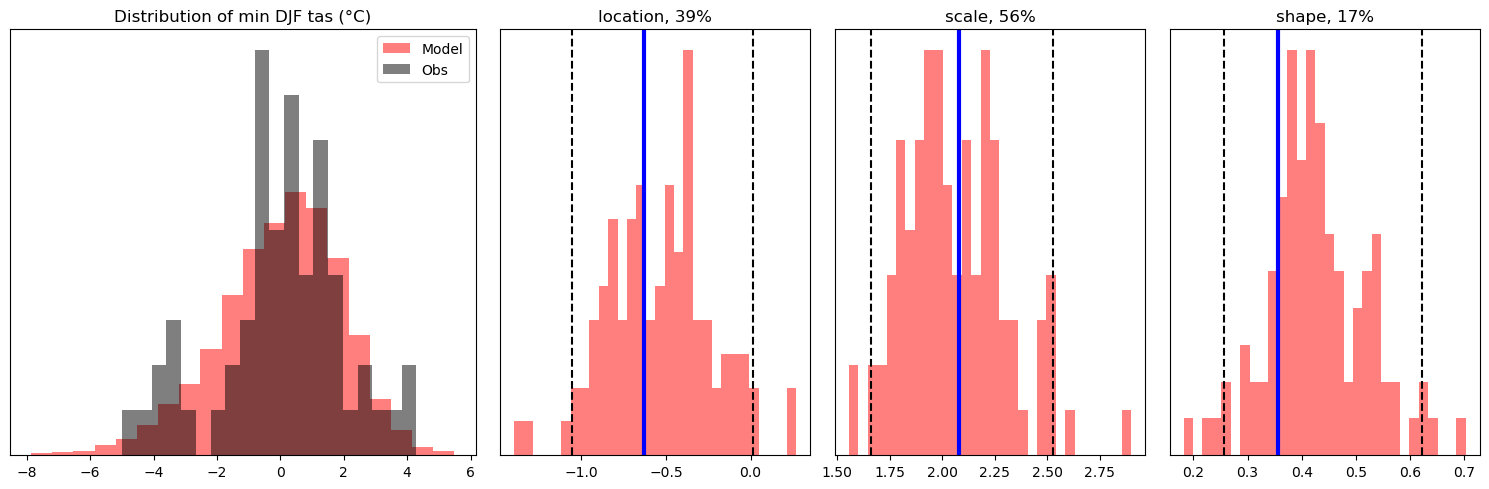

In [18]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_lowest_tas_day_djf["data_dt"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_lowest_tas_day_djf["data_dt"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of min DJF tas (°C)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc values in red
ax1.hist(gev_params["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc"][0], loc_obs)

ax1.set_title("location, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale values in red
ax2.hist(gev_params["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale"][0], scale_obs)

ax2.set_title("scale, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape values in red
ax3.hist(gev_params["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape"][0], shape_obs)

ax3.set_title("shape, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()

### Convert temperature to electricity demand ###

In [70]:
df_obs_tas.head()

,time,data,data_c,effective_dec_year
335,1960-12-01,281.183557,8.033557,1960
336,1960-12-02,279.261101,6.111101,1960
337,1960-12-03,281.323831,8.173831,1960
338,1960-12-04,279.943259,6.793259,1960
339,1960-12-05,277.735919,4.585919,1960


In [71]:
df_model_tas_djf_first.head()

,init_year,member,lead,data,winter_year,effective_dec_year,data_c
30,1960,1,31,279.573264,1,1960,6.423264
31,1960,1,32,281.909420,1,1960,8.759420
32,1960,1,33,280.446810,1,1960,7.296810
33,1960,1,34,279.018759,1,1960,5.868759
34,1960,1,35,277.147551,1,1960,3.997551


In [72]:
# Set up hdd and cdd
hdd_base = 15.5
cdd_base = 22.0

# Process the obs data
df_obs_tas['hdd'] = df_obs_tas['data_c'].apply(lambda x: max(0, hdd_base - x))
df_obs_tas['cdd'] = df_obs_tas['data_c'].apply(lambda x: max(0, x - cdd_base))

# process the model data
df_model_tas_djf_first['hdd'] = df_model_tas_djf_first['data_c'].apply(lambda x: max(0, hdd_base - x))
df_model_tas_djf_first['cdd'] = df_model_tas_djf_first['data_c'].apply(lambda x: max(0, x - cdd_base))

In [74]:
# Set up the path to the regression coeffs
regr_coeffs = "/home/users/benhutch/ERA5_energy_update/ERA5_Regression_coeffs_demand_model.csv"

# load the regression coeffs
df_regr = pd.read_csv(regr_coeffs)

# Set the index
df_regr.set_index("Unnamed: 0", inplace=True)

# Rename the columns by splitting by _ and extracting the second element
df_regr.columns = [x.split("_")[0] for x in df_regr.columns]

# if there is a column called "United" replace it with "United Kingdom"
if "United" in df_regr.columns:
    df_regr.rename(columns={"United": "United_Kingdom"}, inplace=True)

# extract the coeffs for the UK
time_coeff_uk = df_regr.loc["time", "United_Kingdom"]
hdd_coeff_uk = df_regr.loc["HDD", "United_Kingdom"]
cdd_coeff_uk = df_regr.loc["CDD", "United_Kingdom"]

# Calculate the obs demand
df_obs_tas["UK_demand"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk * df_obs_tas["hdd"]) +
    (cdd_coeff_uk * df_obs_tas["cdd"])
)

# Calculate the model demand
df_model_tas_djf_first["UK_demand"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk *df_model_tas_djf_first["hdd"]) +
    (cdd_coeff_uk *df_model_tas_djf_first["cdd"])
)

In [80]:
from GEV_functions import block_min_max_obs

In [76]:
df_obs_tas.head()

,time,data,data_c,effective_dec_year,hdd,cdd,UK_demand
335,1960-12-01,281.183557,8.033557,1960,7.466443,0,40.638064
336,1960-12-02,279.261101,6.111101,1960,9.388899,0,42.075309
337,1960-12-03,281.323831,8.173831,1960,7.326169,0,40.533194
338,1960-12-04,279.943259,6.793259,1960,8.706741,0,41.565322
339,1960-12-05,277.735919,4.585919,1960,10.914081,0,43.215548


In [78]:
# set time as a datetime index
df_obs_tas.set_index("time", inplace=True)

In [87]:
# reload the function
import importlib

import GEV_functions as gev_f

In [88]:
# reload the module
importlib.reload(gev_f)

<module 'GEV_functions' from '/home/users/benhutch/unseen_multi_year/GEV_functions.py'>

In [89]:
# Process the block maxima demand for the winter years
# apply the function
df_obs_highest_demand_day_djf = gev_f.block_min_max_obs(
    obs_df=df_obs_tas,
    month_ints=[12, 1, 2],
    var_name="UK_demand",
    min_max="max",
    time_name="effective_dec_year",
)

In [91]:
df_obs_highest_demand_day_djf.tail()

,effective_dec_year,block_min_max_time,data_value
0,2013,2014-01-30,44.624181
0,2014,2015-01-19,46.775867
0,2015,2016-01-16,46.232551
0,2016,2017-01-05,45.851640
0,2017,2018-02-28,49.498016


In [92]:
# do the same but for the model data
df_model_highest_demand_day_djf = pd.DataFrame()

# Loop over the init years
for init_year in df_model_tas_djf_first["init_year"].unique():
    for member in df_model_tas_djf_first["member"].unique():
        # subset the data
        df_this = df_model_tas_djf_first[
            (df_model_tas_djf_first["init_year"] == init_year)
            & (df_model_tas_djf_first["member"] == member)
        ]

        # if df_this is an empty sequence, print th init_year, member and winter_year
        if df_this.empty:
            print(f"init_year: {init_year}, member: {member}")

        # find the lowest wind day
        highest_demand_day = df_this["UK_demand"].idxmax()

        # Create a new dataframe
        df_new = pd.DataFrame(
            {
                "init_year": [init_year],
                "member": [member],
                "time": [highest_demand_day],
                "data": [df_this.loc[highest_demand_day, "UK_demand"]],
            }
        )

        # Append to the new dataframe
        df_model_highest_demand_day_djf = pd.concat([df_model_highest_demand_day_djf, df_new])

In [94]:
df_model_highest_demand_day_djf.head()

,init_year,member,time,data
0,1960,1,3694,54.988504
0,1960,2,4196,55.014046
0,1960,3,9354,52.120659
0,1960,4,11692,51.975031
0,1960,5,18692,52.401584


In [128]:
# Remove the trend from the obs data
# fit a linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_obs_highest_demand_day_djf["effective_dec_year"],
    df_obs_highest_demand_day_djf["data_value"],
)

# Calculate the trend line values
trend_line = intercept + slope * df_obs_highest_demand_day_djf["effective_dec_year"]

# Determine the final point in the trend line
final_point = trend_line.iloc[-1]

# Create a new column for the pivoted data
df_obs_highest_demand_day_djf["data_dt"] = final_point - trend_line + df_obs_highest_demand_day_djf["data_value"]

In [129]:
df_obs_highest_demand_day_djf.head()

,effective_dec_year,block_min_max_time,data_value,data_dt
0,1960,1961-01-11,46.937737,45.140496
0,1961,1962-01-01,49.236874,47.471165
0,1962,1963-01-12,51.695675,49.961496
0,1963,1963-12-20,48.559905,46.857257
0,1964,1964-12-28,49.140870,47.469752


In [105]:
# Calculate the ensemble mean slope and intercept
dps_slopes = np.zeros(10)
dps_intercepts = np.zeros(10)

# Loop over the members
for i, member in enumerate(df_model_highest_demand_day_djf["member"].unique()):
    # subset the data
    df_this = df_model_highest_demand_day_djf[
        df_model_highest_demand_day_djf["member"] == member
    ]

    # # print(df_this)
    # print(df_this)

    # fit a linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_this["init_year"],
        df_this["data"],
    )

    dps_slopes[i] = slope
    dps_intercepts[i] = intercept

# Calculate the ensemble mean slope and intercept
dps_slope = dps_slopes.mean()
dps_intercept = dps_intercepts.mean()

# Set up the model trend line
model_trend_line = dps_intercept + dps_slope * df_model_highest_demand_day_djf["init_year"]

# determine the finla point in the trend line
final_point_model_tl = model_trend_line.iloc[-1]

df_model_highest_demand_day_djf["data_dt"] = final_point_model_tl - model_trend_line + df_model_highest_demand_day_djf["data"]

# create a new column in df_model_highest_demand_day_djf for the data_dt
# which is the residual after the linear trend has been removed
# df_model_highest_demand_day_djf["data_dt"] = df_model_highest_demand_day_djf["data"] - (dps_intercept + dps_slope * df_model_highest_demand_day_djf["init_year"])

In [106]:
df_model_highest_demand_day_djf.head()

,init_year,member,time,data,data_dt
0,1960,1,3694,54.988504,52.066758
0,1960,2,4196,55.014046,52.092300
0,1960,3,9354,52.120659,49.198913
0,1960,4,11692,51.975031,49.053285
0,1960,5,18692,52.401584,49.479838


Text(0.5, 1.0, 'UK DJF block maxima electricity demand 1960-2017')

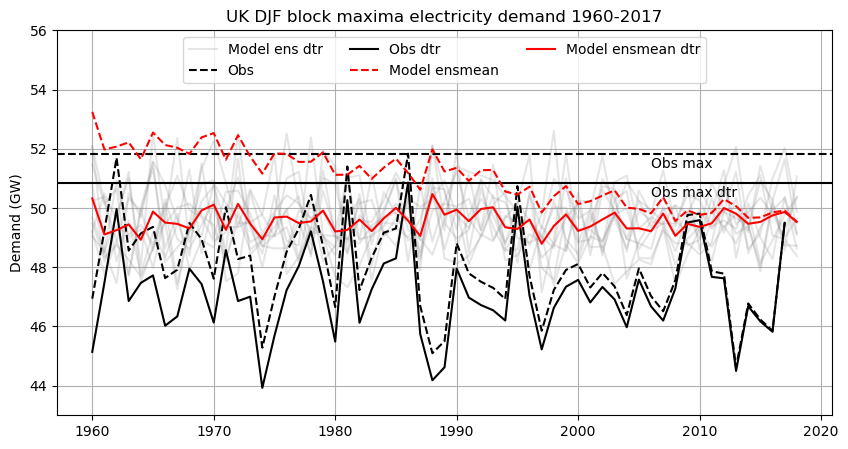

In [112]:
# Set up the figure
# set up a figure with size 10x5
fig, ax = plt.subplots(figsize=(10, 5))

# Loop over the unique members
for i, member in enumerate(df_model_highest_demand_day_djf["member"].unique()):
    # Select the data for this member
    df_member = df_model_highest_demand_day_djf[df_model_highest_demand_day_djf["member"] == member]

    # if i = 0
    if i == 0:
        # plot the data detrended in grey with a label
        ax.plot(df_member["init_year"], df_member["data_dt"], color="grey", alpha=0.2, label="Model ens dtr")
    else:
        # plot the data detrended in grey
        ax.plot(df_member["init_year"], df_member["data_dt"], color="grey", alpha=0.2)

# plot the observed time series (no dt) as a black dashed line
ax.plot(df_obs_highest_demand_day_djf["effective_dec_year"], df_obs_highest_demand_day_djf["data_value"], color="black", linestyle="--", label="Obs")

# plot the observed time series (dt) as a black solid line
ax.plot(df_obs_highest_demand_day_djf["effective_dec_year"], df_obs_highest_demand_day_djf["data_bc"], color="black", label="Obs dtr")

# include a dashed solid black line for the min value of the observed data (no dt)
ax.axhline(df_obs_highest_demand_day_djf["data_value"].max(), color="black", linestyle="--")

# include a solid black line for the min value of the observed data (dt)
ax.axhline(df_obs_highest_demand_day_djf["data_bc"].max(), color="black")

# include text on these lines
ax.text(
    2006,
    df_obs_highest_demand_day_djf["data_value"].max() - 0.1,
    f"Obs max",
    color="black",
    verticalalignment="top",
)

ax.text(
    2006,
    df_obs_highest_demand_day_djf["data_bc"].max() - 0.1,
    f"Obs max dtr",
    color="black",
    verticalalignment="top",
)

# ad a red line for the ensemble mean of the model data (no dt)
# mean over all of the members
ax.plot(df_model_highest_demand_day_djf["init_year"].unique(), df_model_highest_demand_day_djf.groupby("init_year")["data"].mean(), color="red", linestyle="--", label="Model ensmean")

# add a red line for the ensemble mean of the model data (dt)
# mean over all of the members
ax.plot(df_model_highest_demand_day_djf["init_year"].unique(), df_model_highest_demand_day_djf.groupby("init_year")["data_dt"].mean(), color="red", label="Model ensmean dtr")

# Include gridlines 
ax.grid(True)

# Include the y label with the degrees symbol
ax.set_ylabel("Demand (GW)")

# include a legend
ax.legend(loc="upper center", ncol=3)

# Set up the ylims
ax.set_ylim(43, 56)

# Set up the title
ax.set_title("UK DJF block maxima electricity demand 1960-2017")

In [114]:
# bias correct the model data
bias = df_obs_highest_demand_day_djf["data_bc"].mean() - df_model_highest_demand_day_djf["data_dt"].mean()

# apply the bias correction
df_model_highest_demand_day_djf["data_dt_bc"] = df_model_highest_demand_day_djf["data_dt"] + bias

# print the size of the bias
print(f"bias: {bias}")

bias: -2.427327105029221


In [141]:
df_obs_highest_demand_day_djf["data_dt"]

0    45.140496
0    47.471165
0    49.961496
0    46.857257
0    47.469752
0    47.722476
0    46.024509
0    46.338859
0    47.948870
0    47.431114
0    46.131013
0    48.576554
0    46.856402
0    47.004934
0    43.925789
0    45.686320
0    47.227148
0    48.036037
0    49.211514
0    47.512369
0    45.489345
0    50.263796
0    46.124685
0    47.249862
0    48.125296
0    48.298518
0    50.856181
0    45.739834
0    44.181364
0    44.621549
0    47.954534
0    46.974174
0    46.720859
0    46.545362
0    46.200402
0    50.041705
0    47.037782
0    45.225530
0    46.631962
0    47.340714
0    47.572345
0    46.810656
0    47.333017
0    46.909773
0    45.973197
0    47.580968
0    46.676954
0    46.197284
0    47.277757
0    49.508755
0    49.588033
0    47.673592
0    47.624291
0    44.498058
0    46.681276
0    46.169490
0    45.820109
0    49.498016
Name: data_dt, dtype: float64

In [142]:
# Fit a gev model to the observation of electricity demand
shape_obs_demand, loc_obs_demand, scale_obs_demand = gev.fit(df_obs_highest_demand_day_djf["data_dt"])

In [118]:
# Fit a gev model to the observation of electricity demand
shape_obs_demand, loc_obs_demand, scale_obs_demand = gev.fit(df_obs_highest_demand_day_djf["data_dt"])

# Set up the nboot
nboot = 10000

# set up a dictionary to store the gev params
gev_params_demand = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
    "shape_bc": [np.zeros(nboot)],
    "loc_bc": [np.zeros(nboot)],
    "scale_bc": [np.zeros(nboot)],
}

# Set up the number of unique members in the model data
n_members = df_model_highest_demand_day_djf["member"].nunique()

# loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_highest_demand_day_djf["data_dt"].values)
    pseudo_timeseries_this_bc = np.zeros_like(df_obs_highest_demand_day_djf["data_dt"].values)
    for y, year in enumerate(df_obs_highest_demand_day_djf["effective_dec_year"].unique()):
        # Subset the data
        df_model_this = df_model_highest_demand_day_djf[
            df_model_highest_demand_day_djf["init_year"] == year
        ]

        # pick a random memebr
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # subset the data
        df_model_this = df_model_this[
            (df_model_this["member"] == random_member)
        ]

        # get the data
        pseudo_timeseries_this[y] = df_model_this["data_dt"].values[0]
        pseudo_timeseries_this_bc[y] = df_model_this["data_dt_bc"].values[0]

    # fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)
    shape_this_bc, loc_this_bc, scale_this_bc = gev.fit(pseudo_timeseries_this_bc)

    # store the gev params
    gev_params_demand["shape"][0][i] = shape_this
    gev_params_demand["loc"][0][i] = loc_this
    gev_params_demand["scale"][0][i] = scale_this
    gev_params_demand["shape_bc"][0][i] = shape_this_bc
    gev_params_demand["loc_bc"][0][i] = loc_this_bc
    gev_params_demand["scale_bc"][0][i] = scale_this_bc

  0%|          | 2/10000 [00:00<11:45, 14.17it/s]

100%|██████████| 10000/10000 [11:59<00:00, 13.89it/s]


In [127]:
df_obs_highest_demand_day_djf.head()

,effective_dec_year,block_min_max_time,data_value
0,1960,1961-01-11,46.937737
0,1961,1962-01-01,49.236874
0,1962,1963-01-12,51.695675
0,1963,1963-12-20,48.559905
0,1964,1964-12-28,49.140870


In [126]:
# remove the data_dt column from the df_obs_highest_demand_day_djf
# drop the column in position 3
df_obs_highest_demand_day_djf.drop(df_obs_highest_demand_day_djf.columns[3], axis=1, inplace=True)

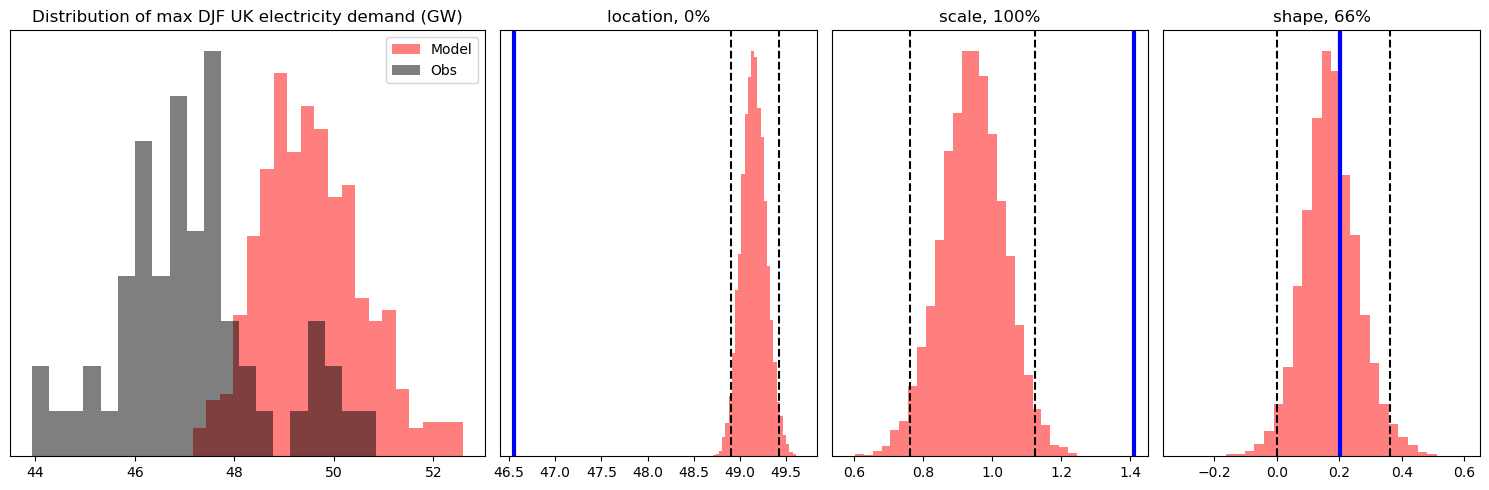

In [143]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_highest_demand_day_djf["data_dt"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_highest_demand_day_djf["data_dt"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of max DJF UK electricity demand (GW)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc_bc values in red
ax1.hist(gev_params_demand["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params_demand["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params_demand["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params_demand["loc"][0], loc_obs_demand)

ax1.set_title("location, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs_demand, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale_bc values in red
ax2.hist(gev_params_demand["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params_demand["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params_demand["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params_demand["scale"][0], scale_obs_demand)

ax2.set_title("scale, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs_demand, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape_bc values in red
ax3.hist(gev_params_demand["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params_demand["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params_demand["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params_demand["shape"][0], shape_obs_demand)

ax3.set_title("shape, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs_demand, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()

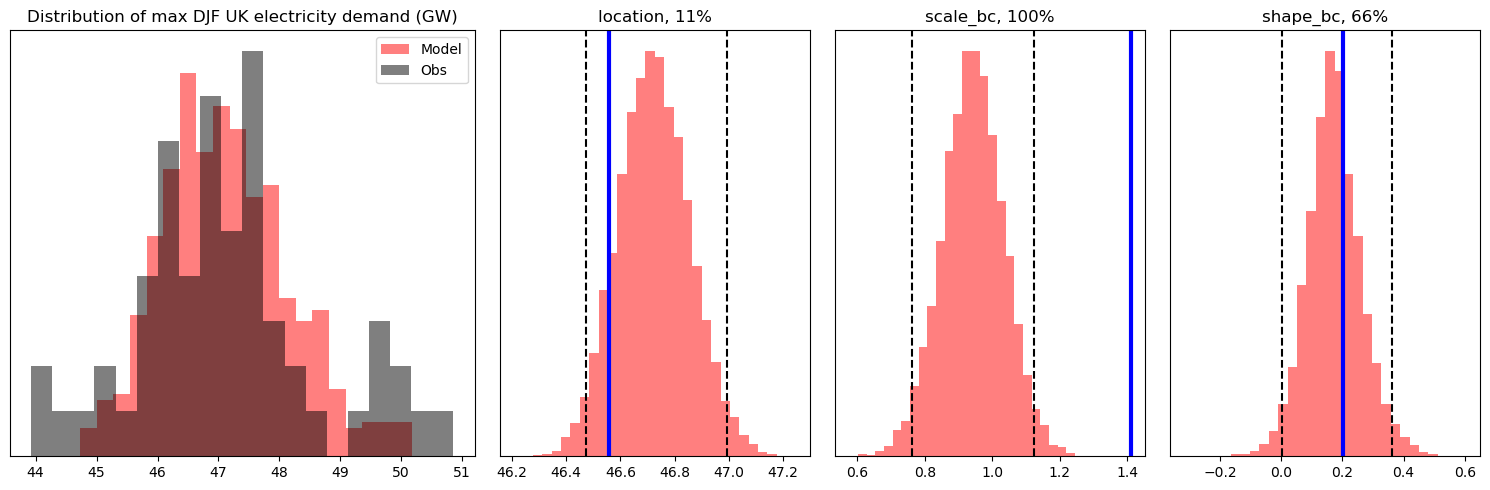

In [140]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_highest_demand_day_djf["data_dt_bc"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_highest_demand_day_djf["data_dt"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of max DJF UK electricity demand (GW)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc_bc values in red
ax1.hist(gev_params_demand["loc_bc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params_demand["loc_bc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params_demand["loc_bc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params_demand["loc_bc"][0], loc_obs_demand)

ax1.set_title("location, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs_demand, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale_bc values in red
ax2.hist(gev_params_demand["scale_bc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params_demand["scale_bc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params_demand["scale_bc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params_demand["scale_bc"][0], scale_obs_demand)

ax2.set_title("scale_bc, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs_demand, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape_bc values in red
ax3.hist(gev_params_demand["shape_bc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params_demand["shape_bc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params_demand["shape_bc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params_demand["shape_bc"][0], shape_obs_demand)

ax3.set_title("shape_bc, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs_demand, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()

### 10m wind speed ###

Now do the same for the 10m wind speed over the UK wind grid box.

In [19]:
# Set up the path to the obs data
obs_wind_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_UK_wind_box_1960-2018_daily_2025-02-26.csv"

# load the obs data
df_obs_wind = pd.read_csv(obs_wind_path)

In [20]:
# Set up a fname for the model data
fname = "HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_UK_wind_box_1960-2018_day.csv"

# Set up the directory in which the model data is stored
model_wind_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# form the complete path
model_wind_path = os.path.join(model_wind_dir, fname)

# if the path exists
if os.path.exists(model_wind_path):
    # load the model data
    df_model_wind = pd.read_csv(model_wind_path)
else:
    # Set up the years
    years = np.arange(1960, 2019)

    # Set up an empty dataframe
    df_model_wind = pd.DataFrame()

    # Loop over the years
    for year in years:
        for member in np.arange(1, 10 + 1):
            # Set up the fname
            fname = f"HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_UK_wind_box_{year}_{member}_day.csv"

            # Set up the path
            path = os.path.join(model_wind_dir, fname)

            # if the path exists
            if os.path.exists(path):
                # Load the data
                df_this = pd.read_csv(path)

                # Append to the main dataframe
                df_model_wind = pd.concat([df_model_wind, df_this])
            else:
                print(f"File does not exist for year {year} and month {member}")

    # Save the dataframe
    df_model_wind.to_csv(model_wind_path, index=False)

In [21]:
# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_wind["time"] = pd.to_datetime(df_obs_wind["time"], origin="1952-01-01", unit="D")

In [22]:
df_obs_wind.tail()

,time,data
21545,2018-12-27,4.083704
21546,2018-12-28,5.164725
21547,2018-12-29,7.375598
21548,2018-12-30,5.961511
21549,2018-12-31,7.909694


In [23]:
# set up the djf winter years
djf_winter_years = np.arange(1, 11 + 1)

# set up a new dataframe to append to
df_model_wind_djf = pd.DataFrame()

# loop over the winter years
for i, wyear in enumerate(djf_winter_years):
    # set up the leads to extract
    leads = np.arange(31 + (i * 360), 31 + 90 + (i * 360))

    # extract the data
    df_model_leads_this = df_model_wind[df_model_wind["lead"].isin(leads)]

    # include a new column
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_wind_djf = pd.concat([df_model_wind_djf, df_model_leads_this])

In [24]:
# Subset the model wind to the first winter
df_model_wind_djf_first = df_model_wind_djf[df_model_wind_djf["winter_year"] == 1]

# add the column for effective dec year to the model data
df_model_wind_djf_first["effective_dec_year"] = df_model_wind_djf_first["init_year"] + (df_model_wind_djf_first["winter_year"] - 1)

In [25]:
# # Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
# df_obs_wind["time"] = pd.to_datetime(df_obs_wind["time"], origin="1950-01-01", unit="D")

# subset the obs data to D, J, F
df_obs_wind = df_obs_wind[df_obs_wind["time"].dt.month.isin([12, 1, 2])]

# new column for temp in C
# df_obs_wind["data_c"] = df_obs_wind["data"] - 273.15

In [26]:
df_obs_wind["effective_dec_year"] = df_obs_wind.apply(
    lambda row: determine_effective_dec_year(row), axis=1
)

In [27]:
# Subset between effective dec years 1960 and 2017
df_obs_wind = df_obs_wind[df_obs_wind["effective_dec_year"].between(1960, 2017)]

# Subset the model data effective dec year between 1960 and 2017
df_model_wind_djf_first = df_model_wind_djf_first[
    df_model_wind_djf_first["effective_dec_year"].between(1960, 2017)
]

In [28]:
df_obs_wind.head()

,time,data,effective_dec_year
335,1960-12-01,10.010098,1960
336,1960-12-02,7.182378,1960
337,1960-12-03,11.876014,1960
338,1960-12-04,11.790759,1960
339,1960-12-05,8.674459,1960


In [29]:
df_obs_lowest_wind_day_djf = pd.DataFrame()

# Loop over the unique effective dec years
for year in df_obs_wind["effective_dec_year"].unique():
    # subset the data
    df_this = df_obs_wind[
        df_obs_wind["effective_dec_year"] == year
    ]

    # find the lowest wind day
    lowest_wind_day = df_this["data"].idxmin()

    # Create a new dataframe
    df_new = pd.DataFrame(
        {
            "effective_dec_year": [year],
            "time": [lowest_wind_day],
            "data": [df_this.loc[lowest_wind_day, "data"]],
        }
    )

    # Append to the new dataframe
    df_obs_lowest_wind_day_djf = pd.concat([df_obs_lowest_wind_day_djf, df_new])

In [30]:
df_model_lowest_wind_day_djf = pd.DataFrame()

# loop over the effective dec years
for init_year in df_model_wind_djf_first["init_year"].unique():
    for member in df_model_wind_djf_first["member"].unique():
        # subset the data
        df_this = df_model_wind_djf_first[
            (df_model_wind_djf_first["init_year"] == init_year)
            & (df_model_wind_djf_first["member"] == member)
        ]

        # # if df_this is an empty sequence, print th init_year, member and winter_year
        # if df_this.empty:
        #     print(f"init_year: {init_year}, member: {member}, winter_year: {winter_year}")

        # find the lowest wind day
        lowest_wind_day = df_this["data"].idxmin()

        # Create a new dataframe
        df_new = pd.DataFrame(
            {
                "init_year": [init_year],
                "member": [member],
                "time": [lowest_wind_day],
                "data": [df_this.loc[lowest_wind_day, "data"]],
            }
        )

        # Append to the new dataframe
        df_model_lowest_wind_day_djf = pd.concat([df_model_lowest_wind_day_djf, df_new])

In [31]:
df_model_lowest_wind_day_djf.head()

,init_year,member,time,data
0,1960,1,104,2.535906
0,1960,2,3806,2.895285
0,1960,3,7608,2.769510
0,1960,4,11325,4.073372
0,1960,5,15094,3.490409


Text(0.5, 1.0, 'UK DJF block minima wind speed 1960-2017')

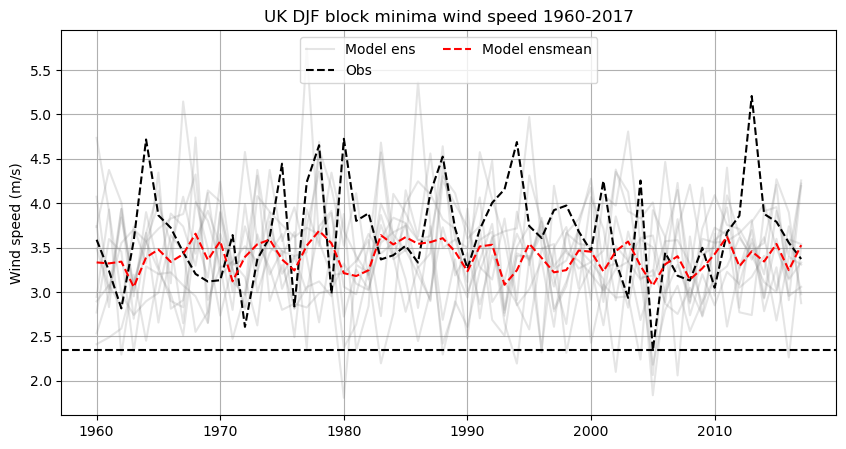

In [32]:
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# # include a horizontal line at 0
# ax.axhline(0, color="grey", linestyle="-.")

# loop over the unique members
for i, member in enumerate(df_model_lowest_wind_day_djf["member"].unique()):
    # Select the data for this member
    df_member = df_model_lowest_wind_day_djf[df_model_lowest_wind_day_djf["member"] == member]

    # if i = 0
    if i == 0:
        # plot the data detrended in grey with a label
        ax.plot(df_member["init_year"], df_member["data"], color="grey", alpha=0.2, label="Model ens")
    else:
        # plot the data detrended in grey
        ax.plot(df_member["init_year"], df_member["data"], color="grey", alpha=0.2)

# plot the observed time series (no dt) as a black dashed line
ax.plot(df_obs_lowest_wind_day_djf["effective_dec_year"], df_obs_lowest_wind_day_djf["data"], color="black", linestyle="--", label="Obs")

# include a dashed solid black line for the min value of the observed data (no dt)
ax.axhline(df_obs_lowest_wind_day_djf["data"].min(), color="black", linestyle="--")

## add a red line for the ensemble mean of the model data (no dt)
# mean over all of the members
ax.plot(df_model_lowest_wind_day_djf["init_year"].unique(), df_model_lowest_wind_day_djf.groupby("init_year")["data"].mean(), color="red", linestyle="--", label="Model ensmean")

# Include gridlines
ax.grid(True)

# Include the y label with the degrees symbol
ax.set_ylabel("Wind speed (m/s)")

# include a legend
# in the top centre
ax.legend(loc="upper center", ncol=2)

# Set up the title
ax.set_title("UK DJF block minima wind speed 1960-2017")

In [33]:
# first fit a gev model to the observations of wind speed
shape_obs, loc_obs, scale_obs = gev.fit(df_obs_lowest_wind_day_djf["data"])

# Now resample the obs to get a distribution of the lowest wind days
# Set up the nboot
nboot = 100

# set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
}

# set up the number of unique members in the model data
n_members = df_model_lowest_wind_day_djf["member"].nunique()

# loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_lowest_wind_day_djf["data"].values)
    for y, year in enumerate(df_obs_lowest_wind_day_djf["effective_dec_year"].unique()):
        # Subset the data
        df_model_this = df_model_lowest_wind_day_djf[
            df_model_lowest_wind_day_djf["init_year"] == year
        ]

        # # select a random year
        # random_year = np.random.choice(df_model_lowest_wind_day_djf["init_year"].unique())

        # Select a random member
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # # Print the random members
        # print(random_member)

        # # print the year
        # print(year)

        # print(df_model_this)

        # subset the data
        df_model_this = df_model_this[
            (df_model_this["member"] == random_member)
        ]

        # # print df model this
        # print(df_model_this)

        # get the data
        pseudo_timeseries_this[y] = df_model_this["data"].values[0]

    # fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)

    # store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["loc"][0][i] = loc_this
    gev_params["scale"][0][i] = scale_this

100%|██████████| 100/100 [00:03<00:00, 25.75it/s]


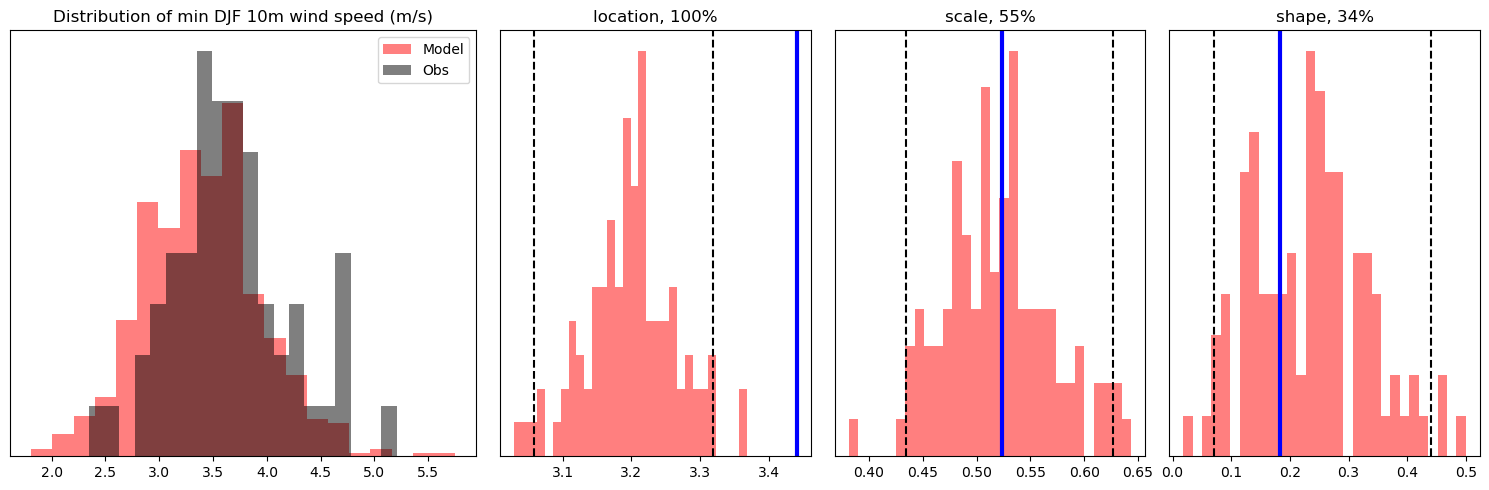

In [34]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_lowest_wind_day_djf["data"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_lowest_wind_day_djf["data"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of min DJF 10m wind speed (m/s)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc values in red
ax1.hist(gev_params["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc"][0], loc_obs)

ax1.set_title("location, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale values in red
ax2.hist(gev_params["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale"][0], scale_obs)

ax2.set_title("scale, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape values in red
ax3.hist(gev_params["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape"][0], shape_obs)

ax3.set_title("shape, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()

In [35]:
# quantify the bias
bias = df_obs_lowest_wind_day_djf["data"].mean() - df_model_lowest_wind_day_djf["data"].mean()

# Set up the bias corrected data
df_model_lowest_wind_day_djf["data_bc"] = df_model_lowest_wind_day_djf["data"] + bias

In [36]:
# first fit a gev model to the observations of wind speed
shape_obs, loc_obs, scale_obs = gev.fit(df_obs_lowest_wind_day_djf["data"])

# Now resample the obs to get a distribution of the lowest wind days
# Set up the nboot
nboot = 100

# set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
}

# set up the number of unique members in the model data
n_members = df_model_lowest_wind_day_djf["member"].nunique()

# loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_lowest_wind_day_djf["data"].values)
    for y, year in enumerate(df_obs_lowest_wind_day_djf["effective_dec_year"].unique()):
        # Subset the data
        df_model_this = df_model_lowest_wind_day_djf[
            df_model_lowest_wind_day_djf["init_year"] == year
        ]

        # # select a random year
        # random_year = np.random.choice(df_model_lowest_wind_day_djf["init_year"].unique())

        # Select a random member
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # # Print the random members
        # print(random_member)

        # # print the year
        # print(year)

        # print(df_model_this)

        # subset the data
        df_model_this = df_model_this[
            (df_model_this["member"] == random_member)
        ]

        # # print df model this
        # print(df_model_this)

        # get the data
        pseudo_timeseries_this[y] = df_model_this["data_bc"].values[0]

    # fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)

    # store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["loc"][0][i] = loc_this
    gev_params["scale"][0][i] = scale_this

  6%|▌         | 6/100 [00:00<00:03, 26.15it/s]

100%|██████████| 100/100 [00:03<00:00, 25.59it/s]


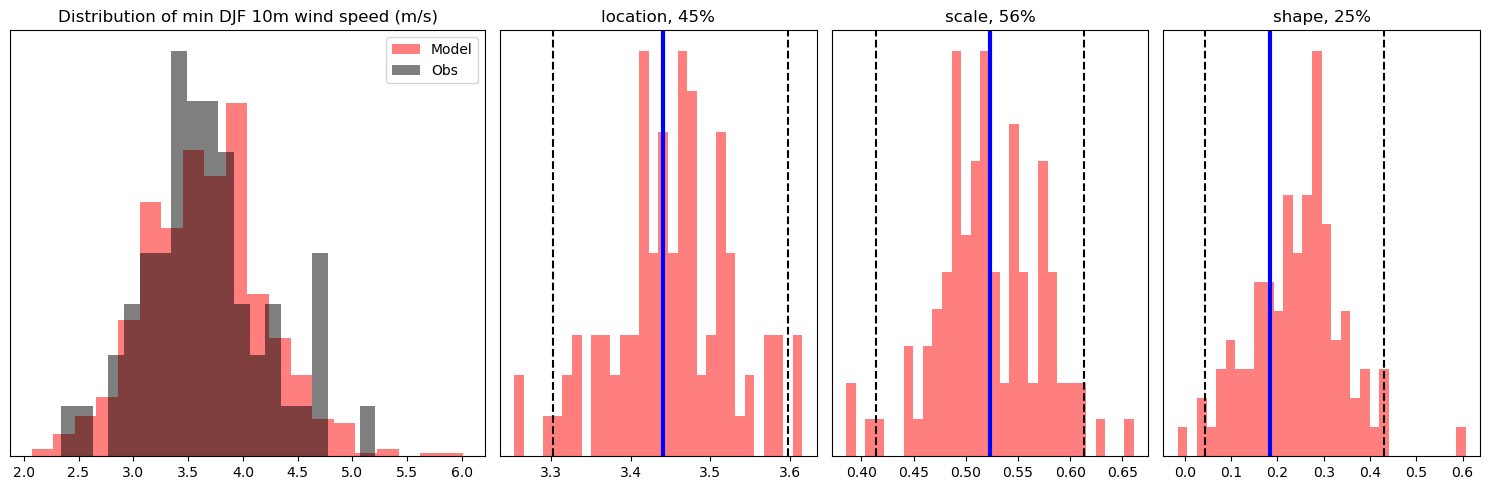

In [37]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_lowest_wind_day_djf["data_bc"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_lowest_wind_day_djf["data"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of min DJF 10m wind speed (m/s)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc values in red
ax1.hist(gev_params["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc"][0], loc_obs)

ax1.set_title("location, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale values in red
ax2.hist(gev_params["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale"][0], scale_obs)

ax2.set_title("scale, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape values in red
ax3.hist(gev_params["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape"][0], shape_obs)

ax3.set_title("shape, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()

Now do the same, but for all of the lead winters, to see whether location parameter changes.

In [38]:
df_model_wind_djf_all = df_model_wind_djf

In [39]:
df_model_wind_djf_all["winter_year"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [40]:
# same for the model data
df_model_lowest_wind_day_djf_all = pd.DataFrame()

# loop over the effective dec years
for init_year in df_model_wind_djf_all["init_year"].unique():
    for member in df_model_wind_djf_all["member"].unique():
        for winter_year in df_model_wind_djf_all["winter_year"].unique():
            # subset the data
            df_this = df_model_wind_djf_all[
                (df_model_wind_djf_all["init_year"] == init_year)
                & (df_model_wind_djf_all["member"] == member)
                & (df_model_wind_djf_all["winter_year"] == winter_year)
            ]

            # if df_this is an empty sequence, print th init_year, member and winter_year
            if df_this.empty:
                print(f"init_year: {init_year}, member: {member}, winter_year: {winter_year}")

            # find the lowest wind day
            lowest_tas_day = df_this["data"].idxmin()

            # Create a new dataframe
            df_new = pd.DataFrame(
                {
                    "init_year": [init_year],
                    "member": [member],
                    "winter_year": [winter_year],
                    "time": [lowest_tas_day],
                    "data": [df_this.loc[lowest_tas_day, "data"]],
                }
            )

            # Append to the new dataframe
            df_model_lowest_wind_day_djf_all = pd.concat([df_model_lowest_wind_day_djf_all, df_new])

In [41]:
df_model_lowest_wind_day_djf_all

,init_year,member,winter_year,time,data
0,1960,1,1,104,2.535906
0,1960,1,2,428,3.029848
0,1960,1,3,776,3.178632
0,1960,1,4,1117,3.485093
0,1960,1,5,1514,3.504391
...,...,...,...,...,...
0,2018,10,7,2211039,3.118710
0,2018,10,8,2211380,3.468538
0,2018,10,9,2211680,3.682478
0,2018,10,10,2212107,3.133574


In [42]:
# add effective dec year column
df_model_lowest_wind_day_djf_all["effective_dec_year"] = df_model_lowest_wind_day_djf_all["init_year"] + (df_model_lowest_wind_day_djf_all["winter_year"] - 1)

Text(0.5, 1.0, 'UK DJF block minima 10m wind speed 1960-2017')

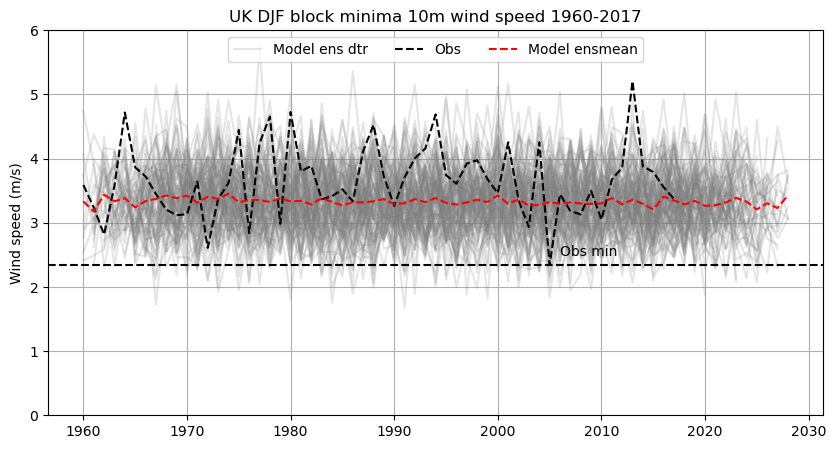

In [43]:
# set up a figure
# set up a figure with size 10x5
fig, ax = plt.subplots(figsize=(10, 5))

# include a horizontal line at 0
# ax.axhline(0, color="grey", linestyle="-.")

# loop over the unique members
for i, member in enumerate(df_model_lowest_wind_day_djf_all["member"].unique()):
    for j, winter_year in enumerate(df_model_lowest_wind_day_djf_all["winter_year"].unique()):
        # Select the data for this member
        df_member = df_model_lowest_wind_day_djf_all[
            (df_model_lowest_wind_day_djf_all["member"] == member)
            & (df_model_lowest_wind_day_djf_all["winter_year"] == winter_year)
        ]

        # if i = 0
        if i == 0 and j == 0:
            # plot the data detrended in grey with a label
            ax.plot(df_member["effective_dec_year"], df_member["data"], color="grey", alpha=0.2, label="Model ens dtr")
        else:
            # plot the data detrended in grey
            ax.plot(df_member["effective_dec_year"], df_member["data"], color="grey", alpha=0.2)

# plot the observed time series (no dt) as a black dashed line
ax.plot(df_obs_lowest_wind_day_djf["effective_dec_year"], df_obs_lowest_wind_day_djf["data"], color="black", linestyle="--", label="Obs")

# # plot the observed time series (dt) as a black solid line
# ax.plot(df_obs_lowest_tas_day_djf["effective_dec_year"], df_obs_lowest_tas_day_djf["data_dt"], color="black", label="Obs dtr")

# include a dashed solid black line for the min value of the observed data (no dt)
ax.axhline(df_obs_lowest_wind_day_djf["data"].min(), color="black", linestyle="--")

# # include a solid black line for the min value of the observed data (dt)
# ax.axhline(df_obs_lowest_tas_day_djf["data_dt"].min(), color="black")

# include text on these lines
ax.text(
    2006,
    df_obs_lowest_wind_day_djf["data"].min() + 0.1,
    f"Obs min",
    color="black",
    verticalalignment="bottom",
)

# ax.text(
#     2006,
#     df_obs_lowest_tas_day_djf["data_dt"].min() + 0.1,
#     f"Obs min dtr",
#     color="black",
#     verticalalignment="bottom",
# )

# ad a red line for the ensemble mean of the model data (no dt)
# mean over all of the members
ax.plot(df_model_lowest_wind_day_djf_all["effective_dec_year"].unique(), df_model_lowest_wind_day_djf_all.groupby("effective_dec_year")["data"].mean(), color="red", linestyle="--", label="Model ensmean")

# # add a red line for the ensemble mean of the model data (dt)
# # mean over all of the members
# ax.plot(df_model_lowest_wind_day_djf_all["effective_dec_year"].unique(), df_model_lowest_wind_day_djf_all.groupby("effective_dec_year")["data_dt"].mean(), color="red", label="Model ensmean dtr")

# Do the same for the canari data
# # mean over all of the members
# ax.plot(df_canari_lowest_tas_day_djf["effective_dec_year"].unique(), df_canari_lowest_tas_day_djf.groupby("effective_dec_year")["data"].mean(), color="blue", linestyle="--", label="Canari no dtr")

# # add a red line for the ensemble mean of the model data (dt)
# # mean over all of the members
# ax.plot(df_canari_lowest_tas_day_djf["effective_dec_year"].unique(), df_canari_lowest_tas_day_djf.groupby("effective_dec_year")["data_dt"].mean(), color="blue", label="Canari dtr")

# Include gridlines
ax.grid(True)

# Include the y label with the degrees symbol
ax.set_ylabel("Wind speed (m/s)")

# include a legend
# in the top centre
ax.legend(loc="upper center", ncol=3)

# set the ylims
ax.set_ylim(0, 6)

# Set up the title
ax.set_title("UK DJF block minima 10m wind speed 1960-2017")

In [44]:
from scipy.stats import genextreme as gev

# First fit a model to the observations
shape_obs, loc_obs, scale_obs = gev.fit(df_obs_lowest_wind_day_djf["data"])

# Now resample the obs to get a distribution of the lowest wind days
# Set up the nboot
nboot = 100

# set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
}

# set up the number of unique members in the model data
n_members = df_model_lowest_wind_day_djf_all["member"].nunique()

# loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_lowest_wind_day_djf["data"].values)
    for y, year in enumerate(df_obs_lowest_wind_day_djf["effective_dec_year"].unique()):
        # Subset the data
        # df_model_this = df_model_lowest_wind_day_djf_all[
        #     df_model_lowest_wind_day_djf_all["effective_dec_year"] == year
        # ]

        # select a random year
        random_year = np.random.choice(df_model_lowest_wind_day_djf_all["winter_year"].unique())

        # Select a random init_year
        random_init_year = np.random.choice(df_model_lowest_wind_day_djf_all["init_year"].unique())

        # subset the data
        df_model_this = df_model_lowest_wind_day_djf_all[
            df_model_lowest_wind_day_djf_all["winter_year"] == random_year
        ]

        # pick a random memebr
        df_model_this = df_model_this[
            df_model_this["init_year"] == random_init_year
        ]

        # pick a random memebr
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # subset the data
        df_model_this = df_model_this[
            df_model_this["member"] == random_member
        ]

        # get the data
        pseudo_timeseries_this[y] = df_model_this["data"].values[0]

    # fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)

    # store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["loc"][0][i] = loc_this
    gev_params["scale"][0][i] = scale_this

  4%|▍         | 4/100 [00:00<00:05, 19.18it/s]

100%|██████████| 100/100 [00:05<00:00, 18.31it/s]


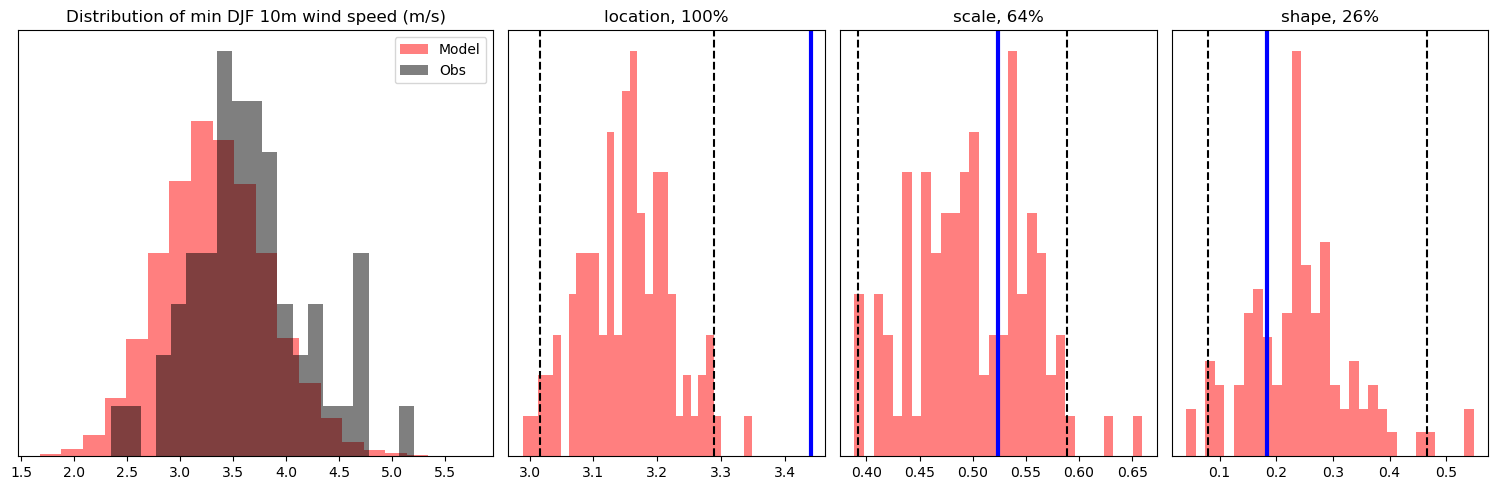

In [45]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_lowest_wind_day_djf_all["data"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_lowest_wind_day_djf["data"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of min DJF 10m wind speed (m/s)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc values in red
ax1.hist(gev_params["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc"][0], loc_obs)

ax1.set_title("location, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale values in red
ax2.hist(gev_params["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale"][0], scale_obs)

ax2.set_title("scale, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape values in red
ax3.hist(gev_params["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape"][0], shape_obs)

ax3.set_title("shape, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()

### Convert wind speed to wind power generation ###

Now do the conversion through to wind power for all of the daily data.

1. Quantify wind power generation ground truth from CLEARHEADS dataset by multiplying the onshore and offshore UK wind power capacity factors by the installed capacities respectively and summing them up.

2. Quantify the relationship between wind power generation and daily UK wind box mean 10m wind speeds using a sigmoid fit.

3. Pass the regridded obs through this sigmoid fit to get our ground truth dataset for wind power generation.

4. Pass all of the daily model data through the sigmoid fit to get the UNSEEN wind power generation.

In [46]:
# Set up the path to the clearheads generation
df_ch = pd.read_csv(
    "/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1960_2018_ONDJFM.csv"
)

# Set up the intalled capacities
# in GW
# https://www.renewableuk.com/energypulse/ukwed/
onshore_capacity = 15710.69 / 1000
offshore_capacity = 14733.02 / 1000

# Set up the clearheads generation
df_ch["ofs_gen"] = df_ch["ofs_cfs"] * offshore_capacity
df_ch["ons_gen"] = df_ch["ons_cfs"] * onshore_capacity

# Set up the total generation
df_ch["total_gen"] = df_ch["ofs_gen"] + df_ch["ons_gen"]

In [47]:
# make sure date is a datetime
df_ch["date"] = pd.to_datetime(df_ch["date"])

# Set date as the index and remove the title
df_ch.set_index("date", inplace=True)

In [48]:
# Subset the data to DJF
df_ch_djf = df_ch[df_ch.index.month.isin([12, 1, 2])]

# Subset the data to between 1960-12-01 and 2017-03-01
df_ch_djf = df_ch_djf["1960-12-01":"2018-03-01"]

In [49]:
df_ch_djf.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind,ofs_gen,ons_gen,total_gen
date,,,,,,,,,,,,,,,,
2018-02-24,0.094450,8.900230,6.189838,192.92108,0.821433,0.351046,2.422172,2.460939,41.512800,45.356712,17.339719,24.173081,28.016993,12.102190,5.515178,17.617368
2018-02-25,0.095563,7.812427,5.467598,194.99629,0.767804,0.258619,1.882640,1.921349,41.037724,45.728540,15.174351,25.863373,30.554189,11.312073,4.063086,15.375160
2018-02-26,0.084250,7.124847,5.003653,170.53311,0.673338,0.217780,0.650934,0.689585,45.918753,46.727023,13.173294,32.745460,33.553730,9.920301,3.421476,13.341777
2018-02-27,0.099030,6.934285,4.908398,199.66423,0.460394,0.270223,-0.583042,-0.544449,47.625528,47.625528,10.810698,36.814830,36.814830,6.782990,4.245383,11.028372
2018-02-28,0.101089,9.864677,7.141508,201.43108,0.822863,0.528296,-3.355289,-3.316753,49.570889,49.570889,19.995807,29.575082,29.575082,12.123253,8.299892,20.423144


In [50]:
# print the unique months in df_obs_wind ["time"] column
df_obs_wind.tail()

,time,data,effective_dec_year
21239,2018-02-24,8.201756,2017
21240,2018-02-25,7.215848,2017
21241,2018-02-26,7.020980,2017
21242,2018-02-27,7.274339,2017
21243,2018-02-28,10.236249,2017


Now fit the sigmoid curve.

In [51]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import (
    sigmoid,
)

In [52]:
# import curve_fit from scipy
from scipy.optimize import curve_fit

# Set up an initial guess for the parameters
p0 = [
    max(df_ch_djf["total_gen"]),
    np.median(df_obs_wind["data"]),
    1,
    min(df_ch_djf["total_gen"]),
]

# Fit the sigmoid curve tro the data=
popt, pcov = curve_fit(
    sigmoid, df_obs_wind["data"], df_ch_djf["total_gen"], p0=p0, method="dogbox"
)

Density range: 0.0 to 0.024676130425688815
Contour interval: 0.008225376808562938


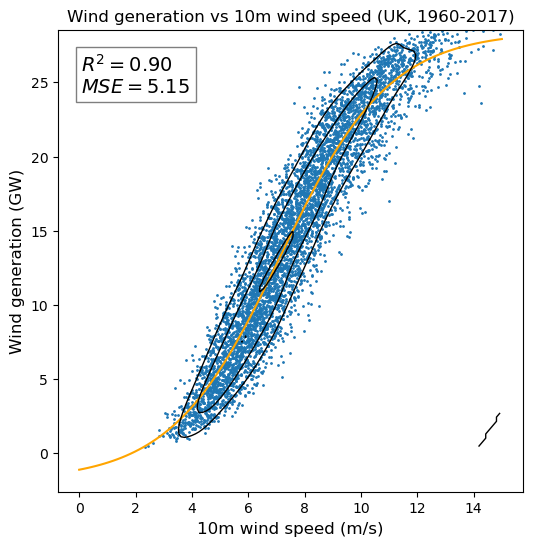

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, mean_squared_error


# Assuming sigmoid and popt are already defined
# Define the sigmoid function if not already defined
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b


# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_wind["data"], df_ch_djf["total_gen"], s=1)

# Plot the sigmoid fit
x = np.linspace(0, round(max(df_obs_wind["data"])), 100)
ax.plot(
    x,
    sigmoid(x, *popt),
    "r-",
    label="fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f" % tuple(popt),
    color="orange",
)

# Calculate the density of the scatter points
xy = np.vstack([df_obs_wind["data"], df_ch_djf["total_gen"]])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = df_obs_wind["data"].min(), df_obs_wind["data"].max()
ymin, ymax = df_ch_djf["total_gen"].min(), df_ch_djf["total_gen"].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors="black", linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch_djf["total_gen"], sigmoid(df_obs_wind["data"], *popt))

# Calculate the mean squared error
mse = mean_squared_error(df_ch_djf["total_gen"], sigmoid(df_obs_wind["data"], *popt))

# Include these values in a textbox in the top left
textstr = "\n".join((r"$R^2=%.2f$" % (r2,), r"$MSE=%.2f$" % (mse,)))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.5),
)

# Set the labels
ax.set_xlabel("10m wind speed (m/s)", fontsize=12)
ax.set_ylabel("Wind generation (GW)", fontsize=12)

# Set the title
ax.set_title("Wind generation vs 10m wind speed (UK, 1960-2017)")

plt.show()

In [54]:
# Now create the sigmoid wind generation from the ERA5 wind obs
# This will be our ground truth
df_obs_wind["sigmoid_total_wind_gen"] = sigmoid(df_obs_wind["data"], *popt)

In [55]:
df_obs_wind.head()

,time,data,effective_dec_year,sigmoid_total_wind_gen
335,1960-12-01,10.010098,1960,22.843254
336,1960-12-02,7.182378,1960,13.444126
337,1960-12-03,11.876014,1960,26.031639
338,1960-12-04,11.790759,1960,25.932243
339,1960-12-05,8.674459,1960,19.002284


In [56]:
df_model_wind_djf_first.head()

,init_year,member,lead,data,winter_year,effective_dec_year
30,1960,1,31,7.861256,1,1960
31,1960,1,32,9.437600,1,1960
32,1960,1,33,12.307897,1,1960
33,1960,1,34,11.076605,1,1960
34,1960,1,35,7.942368,1,1960


In [57]:
# Now apply the sigmoid function to the model data
df_model_wind_djf_first["sigmoid_total_wind_gen"] = sigmoid(df_model_wind_djf_first["data"], *popt)

In [58]:
# # quantify the bias in the wind speeds
# bias = df_obs_wind["data"].mean() - df_model_wind_djf_first["data"].mean()

# # Set up the bias corrected data
# df_model_wind_djf_first["data_bc"] = df_model_wind_djf_first["data"] + bias

# # print the bias
# print(f"Bias: {bias}")

In [59]:
# # new column for bias corrected sigmoid
# df_model_wind_djf_first["sigmoid_total_wind_gen_bc"] = sigmoid(df_model_wind_djf_first["data_bc"], *popt)

In [60]:
# Process the lowest wind generation day for the obs
df_obs_lowest_wind_gen_day_djf = pd.DataFrame()

# Loop over the unique effective dec years
for year in df_obs_wind["effective_dec_year"].unique():
    # Subset the data
    df_this = df_obs_wind[df_obs_wind["effective_dec_year"] == year]

    # Find the lowest wind generation day
    lowest_wind_gen_day = df_this["sigmoid_total_wind_gen"].idxmin()

    # Create a new dataframe
    df_new = pd.DataFrame(
        {
            "effective_dec_year": [year],
            "time": [lowest_wind_gen_day],
            "data": [df_this.loc[lowest_wind_gen_day, "sigmoid_total_wind_gen"]],
        }
    )

    # Append to the new dataframe
    df_obs_lowest_wind_gen_day_djf = pd.concat([df_obs_lowest_wind_gen_day_djf, df_new])

In [62]:
# Do the same for the model data
df_model_lowest_wind_gen_day_djf = pd.DataFrame()

# loop over the effective dec years
for init_year in df_model_wind_djf_first["init_year"].unique():
    for member in df_model_wind_djf_first["member"].unique():
        # subset the data
        df_this = df_model_wind_djf_first[
            (df_model_wind_djf_first["init_year"] == init_year)
            & (df_model_wind_djf_first["member"] == member)
        ]

        # if df_this is an empty sequence, print th init_year, member and winter_year
        if df_this.empty:
            print(f"init_year: {init_year}, member: {member}")

        # find the lowest wind day
        lowest_wind_gen_day = df_this["sigmoid_total_wind_gen"].idxmin()

        # Create a new dataframe
        df_new = pd.DataFrame(
            {
                "init_year": [init_year],
                "member": [member],
                "time": [lowest_wind_gen_day],
                "data": [df_this.loc[lowest_wind_gen_day, "sigmoid_total_wind_gen"]],
            }
        )

        # Append to the new dataframe
        df_model_lowest_wind_gen_day_djf = pd.concat([df_model_lowest_wind_gen_day_djf, df_new])

In [63]:
# Quantify the bias
bias = df_obs_lowest_wind_gen_day_djf["data"].mean() - df_model_lowest_wind_gen_day_djf["data"].mean()

# Set up the bias corrected data
df_model_lowest_wind_gen_day_djf["data_bc"] = df_model_lowest_wind_gen_day_djf["data"] + bias

# priont the bias and the units
print(f"Bias: {bias} GW")

Bias: 0.4830377697451511 GW


In [64]:
# Fit a gev model to the observations of wind generation
shape_obs_wind_gen, loc_obs_wind_gen, scale_obs_wind_gen = gev.fit(df_obs_lowest_wind_gen_day_djf["data"])

# Set up the nboot
nboot = 10000

# Set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "shape_bc": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "loc_bc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
    "scale_bc": [np.zeros(nboot)],
}

# Set up the number of unique members in the model data
n_members = df_model_lowest_wind_gen_day_djf["member"].nunique()

# Loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_lowest_wind_gen_day_djf["data"].values)
    pseudo_timeseries_this_bc = np.zeros_like(df_obs_lowest_wind_gen_day_djf["data"].values)
    for y, year in enumerate(df_obs_lowest_wind_gen_day_djf["effective_dec_year"].unique()):
        # Subset the data
        df_model_this = df_model_lowest_wind_gen_day_djf[
            df_model_lowest_wind_gen_day_djf["init_year"] == year
        ]

        # Select a random member
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # Subset the data
        df_model_this = df_model_this[
            (df_model_this["member"] == random_member)
        ]

        # Get the data
        pseudo_timeseries_this[y] = df_model_this["data"].values[0]
        pseudo_timeseries_this_bc[y] = df_model_this["data_bc"].values[0]

    # Fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)
    shape_this_bc, loc_this_bc, scale_this_bc = gev.fit(pseudo_timeseries_this_bc)

    # Store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["shape_bc"][0][i] = shape_this_bc
    gev_params["loc"][0][i] = loc_this
    gev_params["loc_bc"][0][i] = loc_this_bc
    gev_params["scale"][0][i] = scale_this
    gev_params["scale_bc"][0][i] = scale_this_bc

  0%|          | 2/10000 [00:00<11:01, 15.11it/s]

100%|██████████| 10000/10000 [10:01<00:00, 16.62it/s]


In [65]:
df_model_lowest_wind_gen_day_djf.head()

,init_year,member,time,data,data_bc
0,1960,1,104,0.696312,1.179350
0,1960,2,3806,1.165638,1.648676
0,1960,3,7608,0.993219,1.476256
0,1960,4,11325,3.273830,3.756867
0,1960,5,15094,2.112546,2.595583


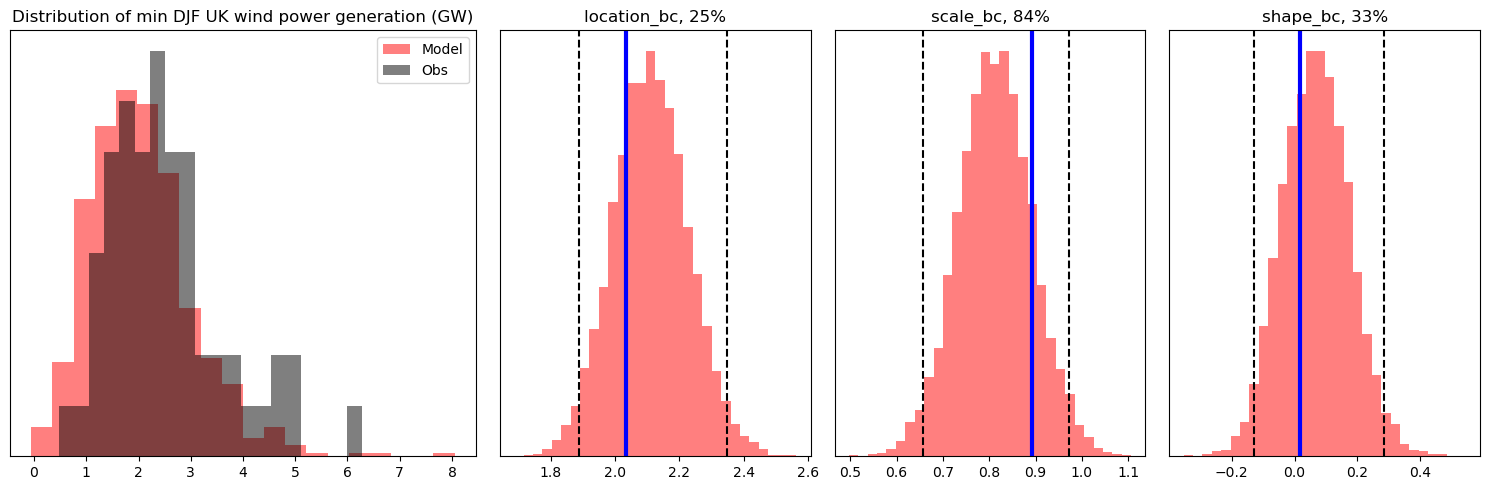

In [137]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_lowest_wind_gen_day_djf["data"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_lowest_wind_gen_day_djf["data"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of min DJF UK wind power generation (GW)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc_bc values in red
ax1.hist(gev_params["loc_bc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc_bc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc_bc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc_bc"][0], loc_obs_wind_gen)

ax1.set_title("location_bc, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs_wind_gen, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale_bc values in red
ax2.hist(gev_params["scale_bc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale_bc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale_bc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale_bc"][0], scale_obs_wind_gen)

ax2.set_title("scale_bc, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs_wind_gen, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape_bc values in red
ax3.hist(gev_params["shape_bc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape_bc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape_bc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape_bc"][0], shape_obs_wind_gen)

ax3.set_title("shape_bc, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs_wind_gen, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()

### Process demand net wind ###

In [151]:
df_obs_wind.head()

,index,time,data,effective_dec_year,sigmoid_total_wind_gen
0,0,1960-12-01,10.010098,1960,22.843254
1,1,1960-12-02,7.182378,1960,13.444126
2,2,1960-12-03,11.876014,1960,26.031639
3,3,1960-12-04,11.790759,1960,25.932243
4,4,1960-12-05,8.674459,1960,19.002284


In [152]:
df_obs_tas.head()

,index,time,data,data_c,effective_dec_year,hdd,cdd,UK_demand
0,0,1960-12-01,281.183557,8.033557,1960,7.466443,0,40.638064
1,1,1960-12-02,279.261101,6.111101,1960,9.388899,0,42.075309
2,2,1960-12-03,281.323831,8.173831,1960,7.326169,0,40.533194
3,3,1960-12-04,279.943259,6.793259,1960,8.706741,0,41.565322
4,4,1960-12-05,277.735919,4.585919,1960,10.914081,0,43.215548


In [153]:
# df obs tas subset removing all cols apart from time and UK_demand
df_obs_tas_subset = df_obs_tas[["time", "UK_demand"]]

In [154]:
# join the obs wind and obs tas
df_obs = df_obs_wind.merge(df_obs_tas_subset, on="time")

In [157]:
df_obs.head()

,index,time,data,effective_dec_year,sigmoid_total_wind_gen,UK_demand,demand_net_wind
0,0,1960-12-01,10.010098,1960,22.843254,40.638064,17.794810
1,1,1960-12-02,7.182378,1960,13.444126,42.075309,28.631183
2,2,1960-12-03,11.876014,1960,26.031639,40.533194,14.501555
3,3,1960-12-04,11.790759,1960,25.932243,41.565322,15.633079
4,4,1960-12-05,8.674459,1960,19.002284,43.215548,24.213264


In [162]:
# remove the trend from the obs_demand data
slope, intercept, r_value, p_value, std_err = stats.linregress(df_obs["effective_dec_year"], df_obs["UK_demand"])

# calculate the trend line
trend_line = intercept + slope * df_obs["effective_dec_year"]

# determine the final point on the trend line
final_point = trend_line.iloc[-1]

# create a new column for the detrended data
df_obs["UK_demand_dt"] = final_point - trend_line + df_obs["UK_demand"]

In [156]:
# calculate the demand net wind for the obs
df_obs["demand_net_wind"] = df_obs["UK_demand"] - df_obs["sigmoid_total_wind_gen"]

In [163]:
df_obs["demand_net_wind_dt"] = df_obs["UK_demand_dt"] - df_obs["sigmoid_total_wind_gen"]

In [158]:
# Do the same for the model data
df_model_wind_djf_first.head()

,init_year,member,lead,data,winter_year,effective_dec_year,sigmoid_total_wind_gen
30,1960,1,31,7.861256,1,1960,16.076000
31,1960,1,32,9.437600,1,1960,21.363600
32,1960,1,33,12.307897,1,1960,26.481603
33,1960,1,34,11.076605,1,1960,24.942395
34,1960,1,35,7.942368,1,1960,16.382283


In [159]:
df_model_tas_djf_first.head()

,init_year,member,lead,data,winter_year,effective_dec_year,data_c,hdd,cdd,UK_demand
30,1960,1,31,279.573264,1,1960,6.423264,9.076736,0,41.841934
31,1960,1,32,281.909420,1,1960,8.759420,6.740580,0,40.095403
32,1960,1,33,280.446810,1,1960,7.296810,8.203190,0,41.188863
33,1960,1,34,279.018759,1,1960,5.868759,9.631241,0,42.256486
34,1960,1,35,277.147551,1,1960,3.997551,11.502449,0,43.655418


In [160]:
# join the dataframes on init_year, member, lead, with suffixes
df_model = df_model_wind_djf_first.merge(df_model_tas_djf_first, on=["init_year", "member", "lead"], suffixes=("_wind", "_tas"))

In [161]:
df_model.head()

,init_year,member,lead,data_wind,winter_year_wind,effective_dec_year_wind,sigmoid_total_wind_gen,data_tas,winter_year_tas,effective_dec_year_tas,data_c,hdd,cdd,UK_demand
0,1960,1,31,7.861256,1,1960,16.076000,279.573264,1,1960,6.423264,9.076736,0,41.841934
1,1960,1,32,9.437600,1,1960,21.363600,281.909420,1,1960,8.759420,6.740580,0,40.095403
2,1960,1,33,12.307897,1,1960,26.481603,280.446810,1,1960,7.296810,8.203190,0,41.188863
3,1960,1,34,11.076605,1,1960,24.942395,279.018759,1,1960,5.868759,9.631241,0,42.256486
4,1960,1,35,7.942368,1,1960,16.382283,277.147551,1,1960,3.997551,11.502449,0,43.655418


In [166]:
# calculate the demand net wind for the model
dps_slopes = np.zeros(10)
dps_intercepts = np.zeros(10)

# Loop over the members
for i, member in enumerate(df_model["member"].unique()):
    # Subset the data
    df_this = df_model[df_model["member"] == member]

    # Fit a linear regression to the data
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_this["init_year"], df_this["UK_demand"])

    # Store the slope
    dps_slopes[i] = slope
    dps_intercepts[i] = intercept

# Calculate the mean slope and intercept
dps_slope_mean = dps_slopes.mean()
dps_intercept_mean = dps_intercepts.mean()

# Calculate the trend line
dps_trend_line = dps_intercept_mean + dps_slope_mean * df_model["init_year"]

# Calculate the final point on the trend line
dps_final_point = dps_trend_line.iloc[-1]

# Create a new column for the detrended data
df_model["UK_demand_dt"] = dps_final_point - dps_trend_line + df_model["UK_demand"]

In [167]:
# calculate the demand net wind
df_model["demand_net_wind"] = df_model["UK_demand"] - df_model["sigmoid_total_wind_gen"]
df_model["demand_net_wind_dt"] = df_model["UK_demand_dt"] - df_model["sigmoid_total_wind_gen"]

In [171]:
df_obs.head()

,index,time,data,effective_dec_year,sigmoid_total_wind_gen,UK_demand,demand_net_wind,UK_demand_dt,demand_net_wind_dt
0,0,1960-12-01,10.010098,1960,22.843254,40.638064,17.794810,39.257434,16.414180
1,1,1960-12-02,7.182378,1960,13.444126,42.075309,28.631183,40.694679,27.250553
2,2,1960-12-03,11.876014,1960,26.031639,40.533194,14.501555,39.152564,13.120925
3,3,1960-12-04,11.790759,1960,25.932243,41.565322,15.633079,40.184692,14.252449
4,4,1960-12-05,8.674459,1960,19.002284,43.215548,24.213264,41.834918,22.832634


In [172]:
# set time as a datetime
df_obs["time"] = pd.to_datetime(df_obs["time"])

# set time as the index
df_obs.set_index("time", inplace=True)

In [173]:
# Quantify the highest obs day
df_obs_highest_demand_net_wind_day_djf = gev_f.block_min_max_obs(
    obs_df=df_obs,
    month_ints=[12, 1, 2],
    var_name="demand_net_wind_dt",
    min_max="max",
    time_name="effective_dec_year",
)

In [174]:
df_obs_highest_demand_net_wind_day_djf.head()

,effective_dec_year,block_min_max_time,data_value
0,1960,1960-12-13,41.972530
0,1961,1961-12-18,43.274263
0,1962,1963-02-22,46.424438
0,1963,1964-02-20,42.621994
0,1964,1964-12-18,40.062115


In [175]:
# do the same for the model data
df_model_highest_demand_net_wind_day_djf = pd.DataFrame()

# loop over the effective dec years
for init_year in df_model["init_year"].unique():
    for member in df_model["member"].unique():
        # subset the data
        df_this = df_model[
            (df_model["init_year"] == init_year)
            & (df_model["member"] == member)
        ]

        # if df_this is an empty sequence, print th init_year, member and winter_year
        if df_this.empty:
            print(f"init_year: {init_year}, member: {member}")

        # find the lowest wind day
        highest_demand_net_wind_day = df_this["demand_net_wind_dt"].idxmax()

        # Create a new dataframe
        df_new = pd.DataFrame(
            {
                "init_year": [init_year],
                "member": [member],
                "time": [highest_demand_net_wind_day],
                "data": [df_this.loc[highest_demand_net_wind_day, "demand_net_wind_dt"]],
            }
        )

        # Append to the new dataframe
        df_model_highest_demand_net_wind_day_djf = pd.concat([df_model_highest_demand_net_wind_day_djf, df_new])

Text(0.5, 1.0, 'UK DJF block maxima demand net wind 1960-2017')

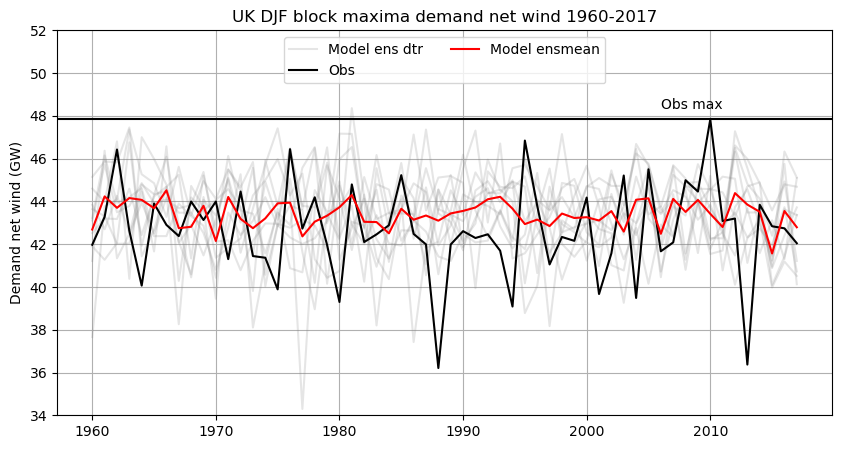

In [181]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# loop over the unique members
for i, member in enumerate(df_model_highest_demand_net_wind_day_djf["member"].unique()):
    # Select the data for this member
    df_member = df_model_highest_demand_net_wind_day_djf[
        df_model_highest_demand_net_wind_day_djf["member"] == member
    ]

    # if i = 0
    if i == 0:
        # plot the data detrended in grey with a label
        ax.plot(df_member["init_year"], df_member["data"], color="grey", alpha=0.2, label="Model ens dtr")
    else:
        # plot the data detrended in grey
        ax.plot(df_member["init_year"], df_member["data"], color="grey", alpha=0.2)

# plot the observed time series (no dt) as a black dashed line
ax.plot(df_obs_highest_demand_net_wind_day_djf["effective_dec_year"], df_obs_highest_demand_net_wind_day_djf["data_value"], color="black", label="Obs")

# # plot the observed time series (dt) as a black solid line
# ax.plot(df_obs_highest_demand_net_wind_day_djf["effective_dec_year"], df_obs_highest_demand_net_wind_day_djf["data_dt"], color="black", label="Obs dtr")

# include a dashed solid black line for the min value of the observed data (no dt)
ax.axhline(df_obs_highest_demand_net_wind_day_djf["data_value"].max(), color="black")

# # # include a solid black line for the min value of the observed data (dt)
# ax.axhline(df_obs_highest_demand_net_wind_day_djf["data_dt"].max(), color="black")

# include text on these lines
ax.text(
    2006,
    df_obs_highest_demand_net_wind_day_djf["data_value"].max() + 1,
    f"Obs max",
    color="black",
    verticalalignment="top",
)

# add a red line for the ensemble mean of the model data (no dt)
# mean over all of the members
ax.plot(df_model_highest_demand_net_wind_day_djf["init_year"].unique(), df_model_highest_demand_net_wind_day_djf.groupby("init_year")["data"].mean(), color="red", label="Model ensmean")

# include gridlines
ax.grid(True)

# include a legend
# in the top centre
ax.legend(loc="upper center", ncol=2)

# Set up the ylabel
ax.set_ylabel("Demand net wind (GW)")

# Set the ylims
ax.set_ylim(34, 52)

# set up the title
ax.set_title("UK DJF block maxima demand net wind 1960-2017")

In [182]:
# Set up the shape obs demand net wind
shape_obs_dnw, loc_obs_dnw, scale_obs_dnw = gev.fit(df_obs_highest_demand_net_wind_day_djf["data_value"])

In [183]:
# quantify the bias
bias = df_obs_highest_demand_net_wind_day_djf["data_value"].mean() - df_model_highest_demand_net_wind_day_djf["data"].mean()

# Set up the bias corrected data
df_model_highest_demand_net_wind_day_djf["data_bc"] = df_model_highest_demand_net_wind_day_djf["data"] + bias

# print the bias
print(f"Bias: {bias} GW")

Bias: -0.7661960973744968 GW


In [184]:
# Set up the nboot
nboot = 10000

# Set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
    "shape_bc": [np.zeros(nboot)],
    "loc_bc": [np.zeros(nboot)],
    "scale_bc": [np.zeros(nboot)],
}

# Set up the number of unique members in the model data
n_members = df_model_highest_demand_net_wind_day_djf["member"].nunique()

# Loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_highest_demand_net_wind_day_djf["data_value"].values)
    pseudo_timeseries_this_bc = np.zeros_like(df_obs_highest_demand_net_wind_day_djf["data_value"].values)
    for y, year in enumerate(df_obs_highest_demand_net_wind_day_djf["effective_dec_year"].unique()):
        # Subset the data
        df_model_this = df_model_highest_demand_net_wind_day_djf[
            df_model_highest_demand_net_wind_day_djf["init_year"] == year
        ]

        # Select a random member
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # Subset the data
        df_model_this = df_model_this[
            (df_model_this["member"] == random_member)
        ]

        # Get the data
        pseudo_timeseries_this[y] = df_model_this["data"].values[0]
        pseudo_timeseries_this_bc[y] = df_model_this["data_bc"].values[0]

    # Fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)
    shape_this_bc, loc_this_bc, scale_this_bc = gev.fit(pseudo_timeseries_this_bc)

    # Store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["shape_bc"][0][i] = shape_this_bc
    gev_params["loc"][0][i] = loc_this
    gev_params["loc_bc"][0][i] = loc_this_bc
    gev_params["scale"][0][i] = scale_this
    gev_params["scale_bc"][0][i] = scale_this_bc

100%|██████████| 10000/10000 [10:41<00:00, 15.59it/s]


In [185]:
df_model_highest_demand_net_wind_day_djf.head()

,init_year,member,time,data,data_bc
0,1960,1,58,43.639759,42.873563
0,1960,2,113,44.598426,43.832230
0,1960,3,201,43.105444,42.339248
0,1960,4,315,41.215899,40.449703
0,1960,5,403,42.520291,41.754095


In [186]:
df_obs_highest_demand_net_wind_day_djf.head()

,effective_dec_year,block_min_max_time,data_value
0,1960,1960-12-13,41.972530
0,1961,1961-12-18,43.274263
0,1962,1963-02-22,46.424438
0,1963,1964-02-20,42.621994
0,1964,1964-12-18,40.062115


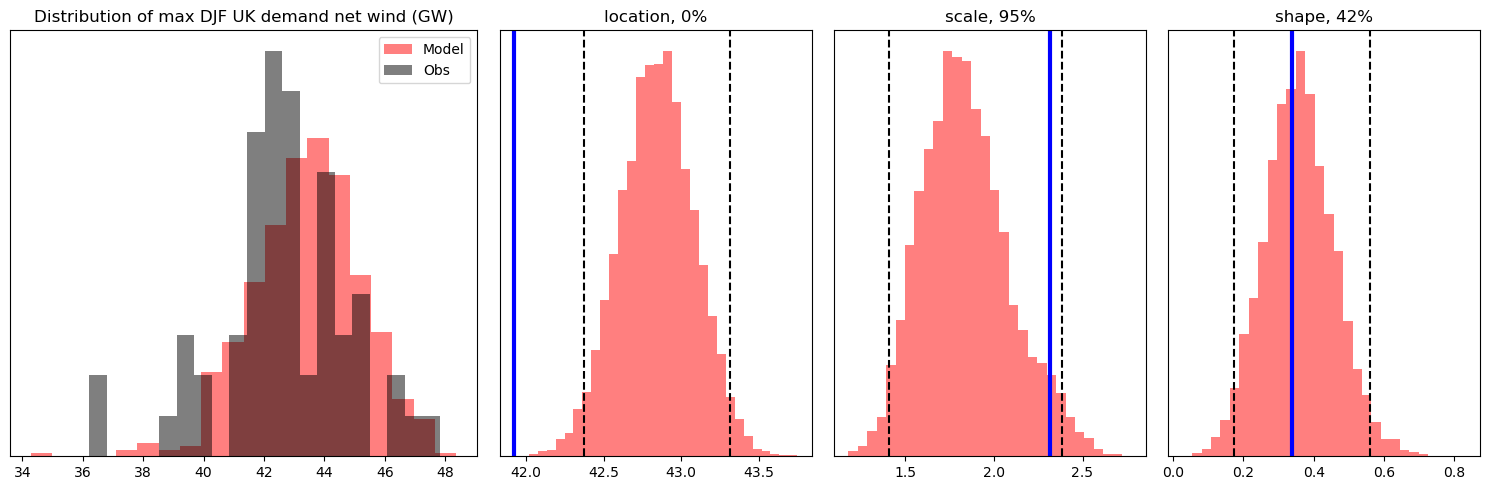

In [187]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_highest_demand_net_wind_day_djf["data"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_highest_demand_net_wind_day_djf["data_value"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of max DJF UK demand net wind (GW)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc_bc values in red
ax1.hist(gev_params["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc"][0], loc_obs_dnw)

ax1.set_title("location, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs_dnw, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale_bc values in red
ax2.hist(gev_params["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale"][0], scale_obs_dnw)

ax2.set_title("scale, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs_dnw, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape_bc values in red
ax3.hist(gev_params["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape"][0], shape_obs_dnw)

ax3.set_title("shape, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs_dnw, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()

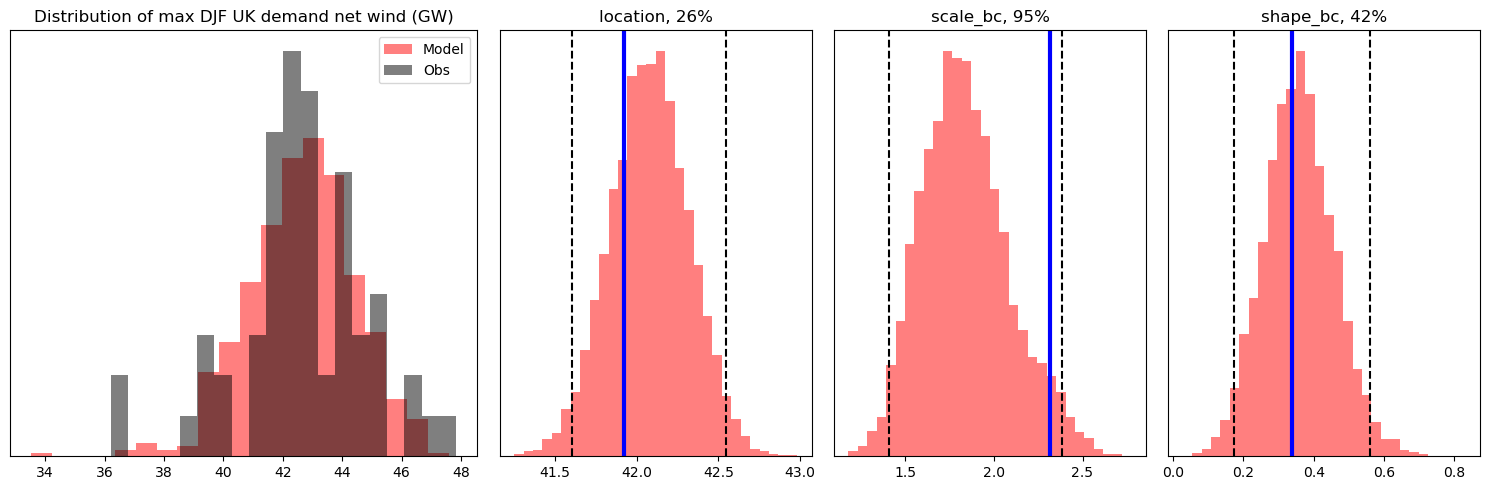

In [188]:
from matplotlib import gridspec

# Set up a subfigure
# with three subplots side by side
# Set up a subfigure with a custom gridspec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5, 1, 1, 1])

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# plot the model distribution
ax0.hist(df_model_highest_demand_net_wind_day_djf["data_bc"], color="red", alpha=0.5, bins=20, density=True, label="Model")

# plot the obs distribution
ax0.hist(df_obs_highest_demand_net_wind_day_djf["data_value"], color="black", alpha=0.5, bins=20, density=True, label="Obs")

# set a title
ax0.set_title("Distribution of max DJF UK demand net wind (GW)")

# include a legend in the top right
ax0.legend(loc="upper right")

# for the second one plot the histogram of loc_bc values in red
ax1.hist(gev_params["loc_bc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc_bc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax1.axvline(
    np.percentile(gev_params["loc_bc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc_bc"][0], loc_obs_dnw)

ax1.set_title("location, {:.0f}%".format(round((obs_percentile_loc))))

# plot the observed value as a vertical line
ax1.axvline(loc_obs_dnw, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale_bc values in red
ax2.hist(gev_params["scale_bc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale_bc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax2.axvline(
    np.percentile(gev_params["scale_bc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale_bc"][0], scale_obs_dnw)

ax2.set_title("scale_bc, {:.0f}%".format(round(obs_percentile_scale)))

# plot the observed value as a vertical line
ax2.axvline(scale_obs_dnw, color="blue", label="ERA5", lw=3)

# for the first one plot the histogram of shape_bc values in red
ax3.hist(gev_params["shape_bc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape_bc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
ax3.axvline(
    np.percentile(gev_params["shape_bc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape_bc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape_bc"][0], shape_obs_dnw)

ax3.set_title("shape_bc, {:.0f}%".format(round(obs_percentile_shape)))

# plot the observed value as a vertical line
ax3.axvline(shape_obs_dnw, color="blue", label="ERA5", lw=3)

# remove the y-axis ticks 
for ax in [ax0, ax1, ax2, ax3]:
    ax.yaxis.set_ticks([])

# Set up a tight layout
plt.tight_layout()